In [1]:
import pandas as pd
from pathlib import Path
from typing import Tuple
from itertools import product
from collections import defaultdict
import json
import numpy as np
from scipy import stats
from math import sqrt
from enum import Enum
from dataclasses import dataclass
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.tri import Triangulation


# plt.style.use("ggplot")
CONF = 0.95


In [2]:
def sample_name(s: str) -> str:
    for sfx in ["_rep1", "_rep2", "-singleplex", "-multiplex"]:
        s = s.replace(sfx, "")
    return s

def load_susceptibility(stream) -> dict:
    """Extract the susceptibility info from the JSON"""
    data = json.load(stream)
    try:
        return data[next(iter(data.keys()))]["susceptibility"]
    except (KeyError, TypeError):
        return data["susceptibility"]

In [3]:
with open("../../docs/final_samples.csv") as fp:
    final_samples = set(fp.read().splitlines()) 
len(final_samples)

72

In [4]:
concdf = pd.read_csv("../../docs/dna_concentrations.csv", index_col="name")

In [5]:
smear_df = pd.read_csv("../../docs/smear_results.csv", index_col="sample")
ont_df = pd.read_csv("../../docs/ont_samples.csv", index_col="sample")

ont_comp_df = pd.read_html("../../results/report/nanopore_composition.html")
assert len(ont_comp_df) == 1
ont_comp_df = ont_comp_df[0]
ont_comp_df.columns = [t[1] if t[0].startswith("Unnam") else t[0] for t in ont_comp_df.columns]
ont_comp_df["source"] = "sputum"
ont_comp_df["technology"] = "nanopore"
ont_comp_df["smear"] = [smear_df.at[sample_name(s), "smear_result"] for s in ont_comp_df["sample"]]
ont_comp_df["is_multiplex"] = [not pd.isna(ont_df.at[s, "barcode_kit"]) for s in  ont_comp_df["sample"]]

illumina_df1 = pd.read_html("../../results/report/illumina_culture_composition.html")
assert len(illumina_df1) == 1
illumina_df1 = illumina_df1[0]
illumina_df1.columns = [t[1] if t[0].startswith("Unnam") else t[0] for t in illumina_df1.columns]
illumina_df1["source"] = "culture"
illumina_df1["technology"] = "illumina"
illumina_df1["smear"] = [smear_df.at[sample_name(s), "smear_result"] for s in illumina_df1["sample"]]

illumina_df2 = pd.read_html("../../results/report/illumina_sputum_composition.html")
assert len(illumina_df2) == 1
illumina_df2 = illumina_df2[0]
illumina_df2.columns = [t[1] if t[0].startswith("Unnam") else t[0] for t in illumina_df2.columns]
illumina_df2["source"] = "sputum"
illumina_df2["technology"] = "illumina"
illumina_df2["smear"] = [smear_df.at[sample_name(s), "smear_result"] for s in illumina_df2["sample"]]

comp_df = pd.concat([ont_comp_df, illumina_df1, illumina_df2])
comp_df.reset_index(inplace=True, drop=True)
# remove replicates
comp_df = comp_df.loc[~comp_df["sample"].str.contains("_rep")]
comp_df["sample"] = [s.split("-s")[0].split("-m")[0] for s in comp_df["sample"]]
comp_df["is_multiplex"].fillna(False, inplace=True)
comp_df.set_index(["sample", "source", "technology", "is_multiplex"], verify_integrity=True, inplace=True)
cov_df = comp_df[comp_df.columns.intersection(["coverage"])]
cov_df

coverage
sample   source technology is_multiplex          
P201     sputum nanopore   True               0.2
P202     sputum nanopore   True               6.0
P203     sputum nanopore   True               1.1
                           False              6.6
P204     sputum nanopore   True               0.1
...                                           ...
Test_NC2 sputum illumina   False              0.5
Test_NC3 sputum illumina   False              1.5
Test_NC4 sputum illumina   False              0.9
Test_NC5 sputum illumina   False              1.9
Test_NC6 sputum illumina   False              1.3

[213 rows x 1 columns]

In [6]:
# ont_df = pd.read_csv("../../docs/ont_samples.csv", index_col="sample")

In [7]:
# jsons = list(Path("../../results/").rglob("*mykrobe.json"))

In [8]:
# data = []
# for p in jsons:
#     with open(p) as fp:
#         results = load_susceptibility(fp)
#     name = p.name.split(".")[0]
#     if "_rep" in name:
#         continue
#     tech = p.parts[3]
#     if tech == "nanopore":
#         is_multi = not pd.isna(ont_df.at[name, "barcode_kit"])
#         source = "sputum"
#     else:
#         is_multi = False
#         source = p.parts[5]
#     name = sample_name(name)
#     for drug, pred in results.items():
#         data.append((name, tech, source, is_multi, drug, pred))

In [9]:
# df = pd.DataFrame(data, columns=["name", "technology", "source", "is_multiplex", "drug", "prediction"])

In [10]:
# df["prediction"] = [d["predict"] for d in df["prediction"]]

In [11]:
# df

In [12]:
# df.to_csv("../../results/dst_predictions.csv", index=False)

In [13]:
df = pd.read_csv("../../results/dst_predictions.csv").query("name in @final_samples")
df

,name,technology,source,is_multiplex,drug,prediction
0,P224,illumina,sputum,False,Ofloxacin,S
1,P224,illumina,sputum,False,Moxifloxacin,S
2,P224,illumina,sputum,False,Isoniazid,S
3,P224,illumina,sputum,False,Kanamycin,S
4,P224,illumina,sputum,False,Ethambutol,S
...,...,...,...,...,...,...
2338,P217,nanopore,sputum,False,Ciprofloxacin,S
2339,P217,nanopore,sputum,False,Pyrazinamide,S
2340,P217,nanopore,sputum,False,Rifampicin,R
2341,P217,nanopore,sputum,False,Amikacin,S


In [14]:
sputum_df = df.query("source=='sputum'")

In [15]:
culture_df = df.query("source=='culture'").set_index(["name", "drug"], verify_integrity=True)

https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html is a good place to get tips for doing this plot

and https://stackoverflow.com/questions/63530701/python-package-to-plot-two-heatmaps-in-one-split-each-square-into-two-triangles

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from itertools import product
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [17]:
set(df["drug"])

{'Amikacin',
 'Capreomycin',
 'Ciprofloxacin',
 'Ethambutol',
 'Isoniazid',
 'Kanamycin',
 'Moxifloxacin',
 'Ofloxacin',
 'Pyrazinamide',
 'Rifampicin',
 'Streptomycin'}

In [18]:
samples = set()
for s, _ in culture_df.index:
    samples.add(s)
    
drugs = ["Isoniazid", "Rifampicin", "Pyrazinamide", "Ethambutol", "Streptomycin", "Amikacin", "Capreomycin", "Kanamycin", "Ciprofloxacin", "Moxifloxacin", "Ofloxacin"]

In [19]:
s = """AMI amikacin
BDQ bedaquiline
CAP capreomycin
CFX ciprofloxacin
CFZ clofazimine
DLM delamanid
EMB ethambutol
ETH ethionamide
INH isoniazid
KAN kanamycin
LEV levofloxacin
LZD linezolid
MFX moxifloxacin
OFX ofloxacin
PZA pyrazinamide
RIF rifampicin
STM streptomycin"""

drug2abbrev = {drug.capitalize(): abbrev for abbrev, drug in map(str.split, s.splitlines())}
abbrev2drug = {abbrev: drug.capitalize() for abbrev, drug in map(str.split, s.splitlines())}

In [20]:
# 4-class RdBu
dark_red = "#ca0020"
light_red = "#f4a582"
light_blue = "#92c5de"
dark_blue = "#0571b0"
colors = [dark_red, light_red, light_blue, dark_blue, "white"]
cmap = ListedColormap(colors)

classmap = {"FN": 0, "FP": 1, "TN": 2, "TP": 3, "NA": 4}

In [21]:
ill_sputum = sputum_df.query("technology=='illumina'")
ill_sputum_names = set(ill_sputum["name"])

In [24]:
cov_clf = []
X = np.zeros((len(samples), len(drugs)))
for i, s in enumerate(sorted(samples, reverse=True)):
    if s not in ill_sputum_names:
        for j, d in enumerate(drugs):
            X[i][j] = classmap["NA"]
        continue
    for j, d in enumerate(drugs):
        expected = culture_df.at[(s, d), "prediction"]
        actual = ill_sputum.query("name==@s and drug==@d")["prediction"].iloc[0]
        
        ix = (s, "sputum", "illumina", False)
        cov = cov_df.at[ix, "coverage"]
        
        if expected == "S":
            if actual == "S":
                clf = "TN"
            else:
                clf = "FP"
        else:
            if actual == "S":
                clf = "FN"
            else:
                clf = "TP"
        cov_clf.append((d, cov, clf, *ix))
        X[i][j] = classmap[clf]

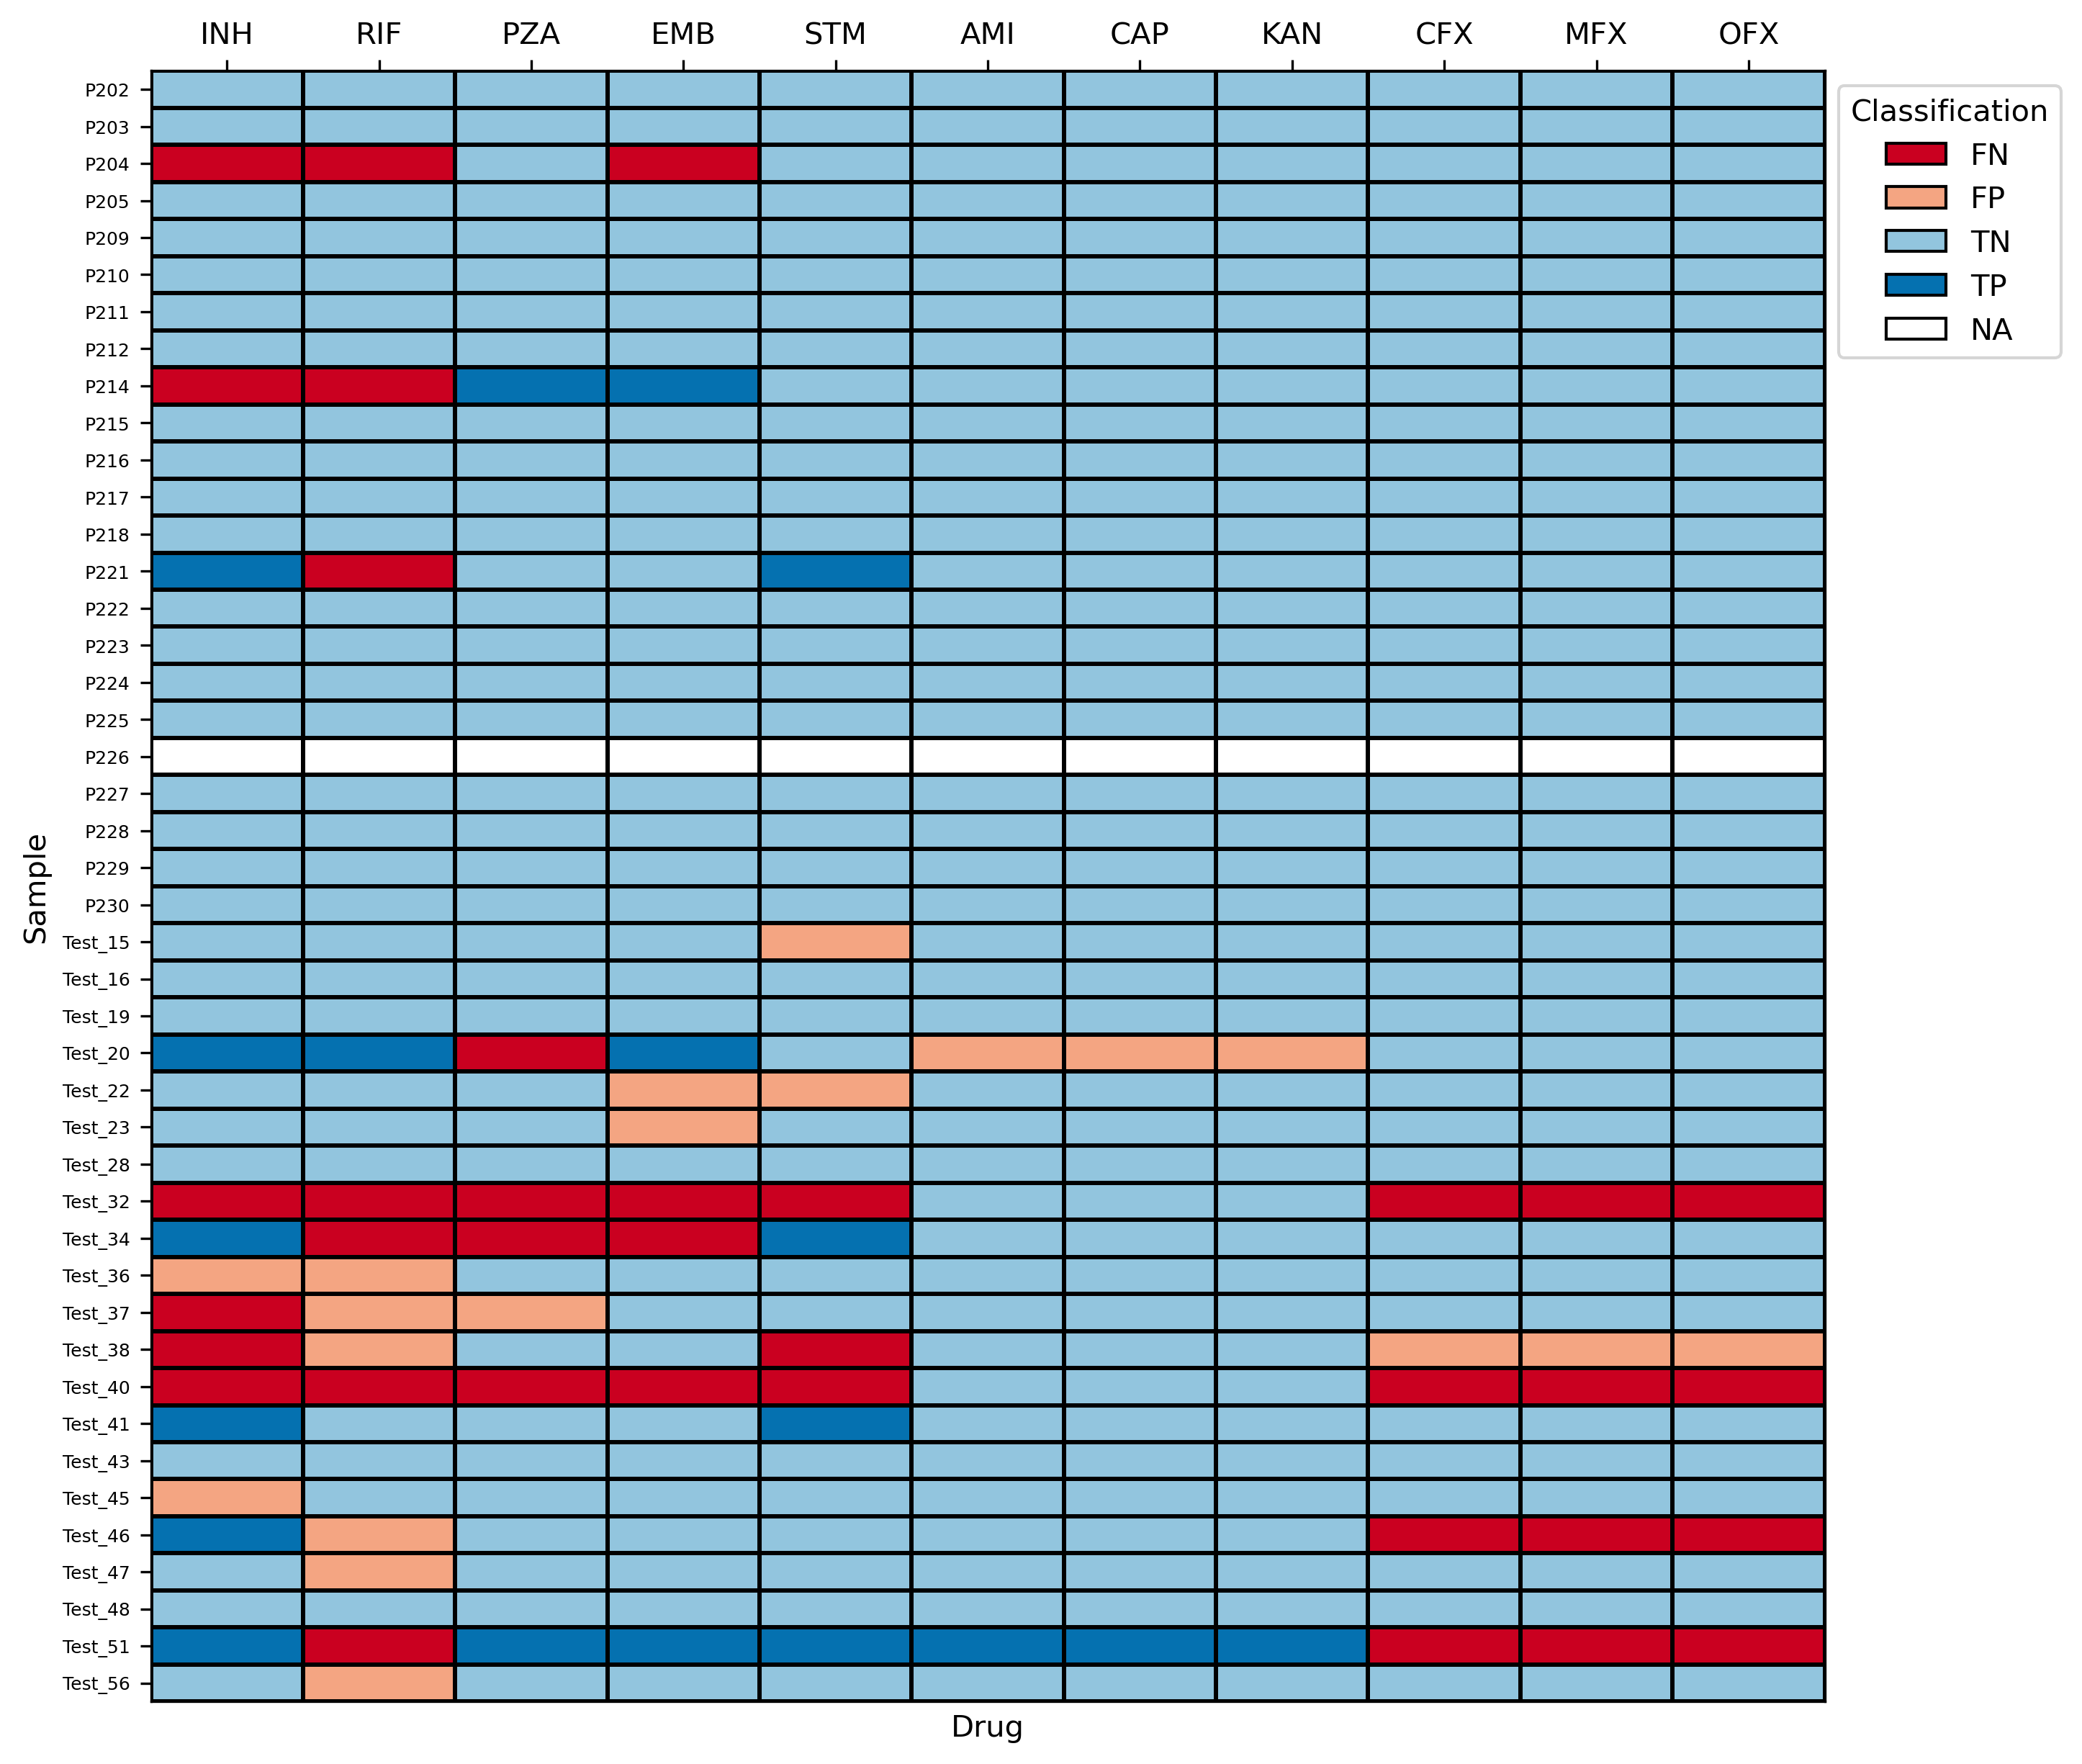

In [25]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.pcolormesh(X, edgecolors='k', linewidth=1, cmap=cmap, vmin=0, vmax=len(colors))
# ax = plt.gca()
# ax.set_aspect('equal')
drug_labels = [drug2abbrev[d] for d in drugs]
_ = ax.set_xticks(np.arange(len(drugs))+0.5, labels=drug_labels)
ax.xaxis.tick_top()
_ = ax.set_yticks(np.arange(len(samples))+0.5, labels=sorted(samples, reverse=True), size=6)

patches = []
for k, v in classmap.items():
    patches.append(mpatches.Patch(facecolor=colors[v], label=k, edgecolor="black"))
ax.set(ylabel="Sample", xlabel="Drug")
plt.legend(handles=patches, title="Classification", bbox_to_anchor=(1.15, 1), loc="upper right")

In [33]:
ont_sputum = sputum_df.query("technology=='nanopore'")
ont_sputum_names = set(ont_sputum["name"])

In [34]:
def add_row_col_padding(arr):
    rows, cols = arr.shape
    return np.r_[np.c_[arr, np.zeros(rows)], [np.zeros(cols+1)]]

In [35]:
ont_sputum.set_index(["name", "is_multiplex", "drug"], inplace=True)

In [36]:
culture_df["prediction"].get(("P224", "drug"))

In [37]:
def classify(actual: str, expected: str) -> int:
    if actual == "NA":
        return classmap["NA"]
    if expected == "S":
        if actual == "S":
            clf = "TN"
        elif actual == "R":
            clf = "FP"
        else:
            raise NotImplementedError(f"Don't know how to handle {actual}")
    elif expected == "R":
        if actual == "S":
            clf = "FN"
        elif actual == "R":
            clf = "TP"
        else:
            raise NotImplementedError(f"Don't know how to handle {actual}")
    else:
        raise NotImplementedError(f"Don't know how to handle {expected}")
    return classmap[clf]

In [38]:
X_mono = np.zeros((len(samples), len(drugs)))
X_multi = np.zeros((len(samples), len(drugs)))
default = "NA"

clfmap = {v: k for k, v in classmap.items()}

for i, s in enumerate(sorted(samples, reverse=True)):
    for j, d in enumerate(drugs):
        expected = culture_df.at[(s, d), "prediction"]
        multi_actual = ont_sputum["prediction"].get((s, True, d), default=default)
        mono_actual = ont_sputum["prediction"].get((s, False, d), default=default)
        
        mono_clf = classify(mono_actual, expected)
        multi_clf = classify(multi_actual, expected)
        
        mono_ix = (s, "sputum", "nanopore", False)
        multi_ix = (s, "sputum", "nanopore", True)
        try:
            mono_cov = cov_df.at[mono_ix, "coverage"]
        except KeyError:
            mono_cov = None
        try:
            multi_cov = cov_df.at[multi_ix, "coverage"]
        except KeyError:
            multi_cov = None
            
        cov_clf.append((d, mono_cov, clfmap[mono_clf], *mono_ix))
        cov_clf.append((d, multi_cov, clfmap[multi_clf], *multi_ix))
        
        X_mono[i][j] = mono_clf
        X_multi[i][j] = multi_clf

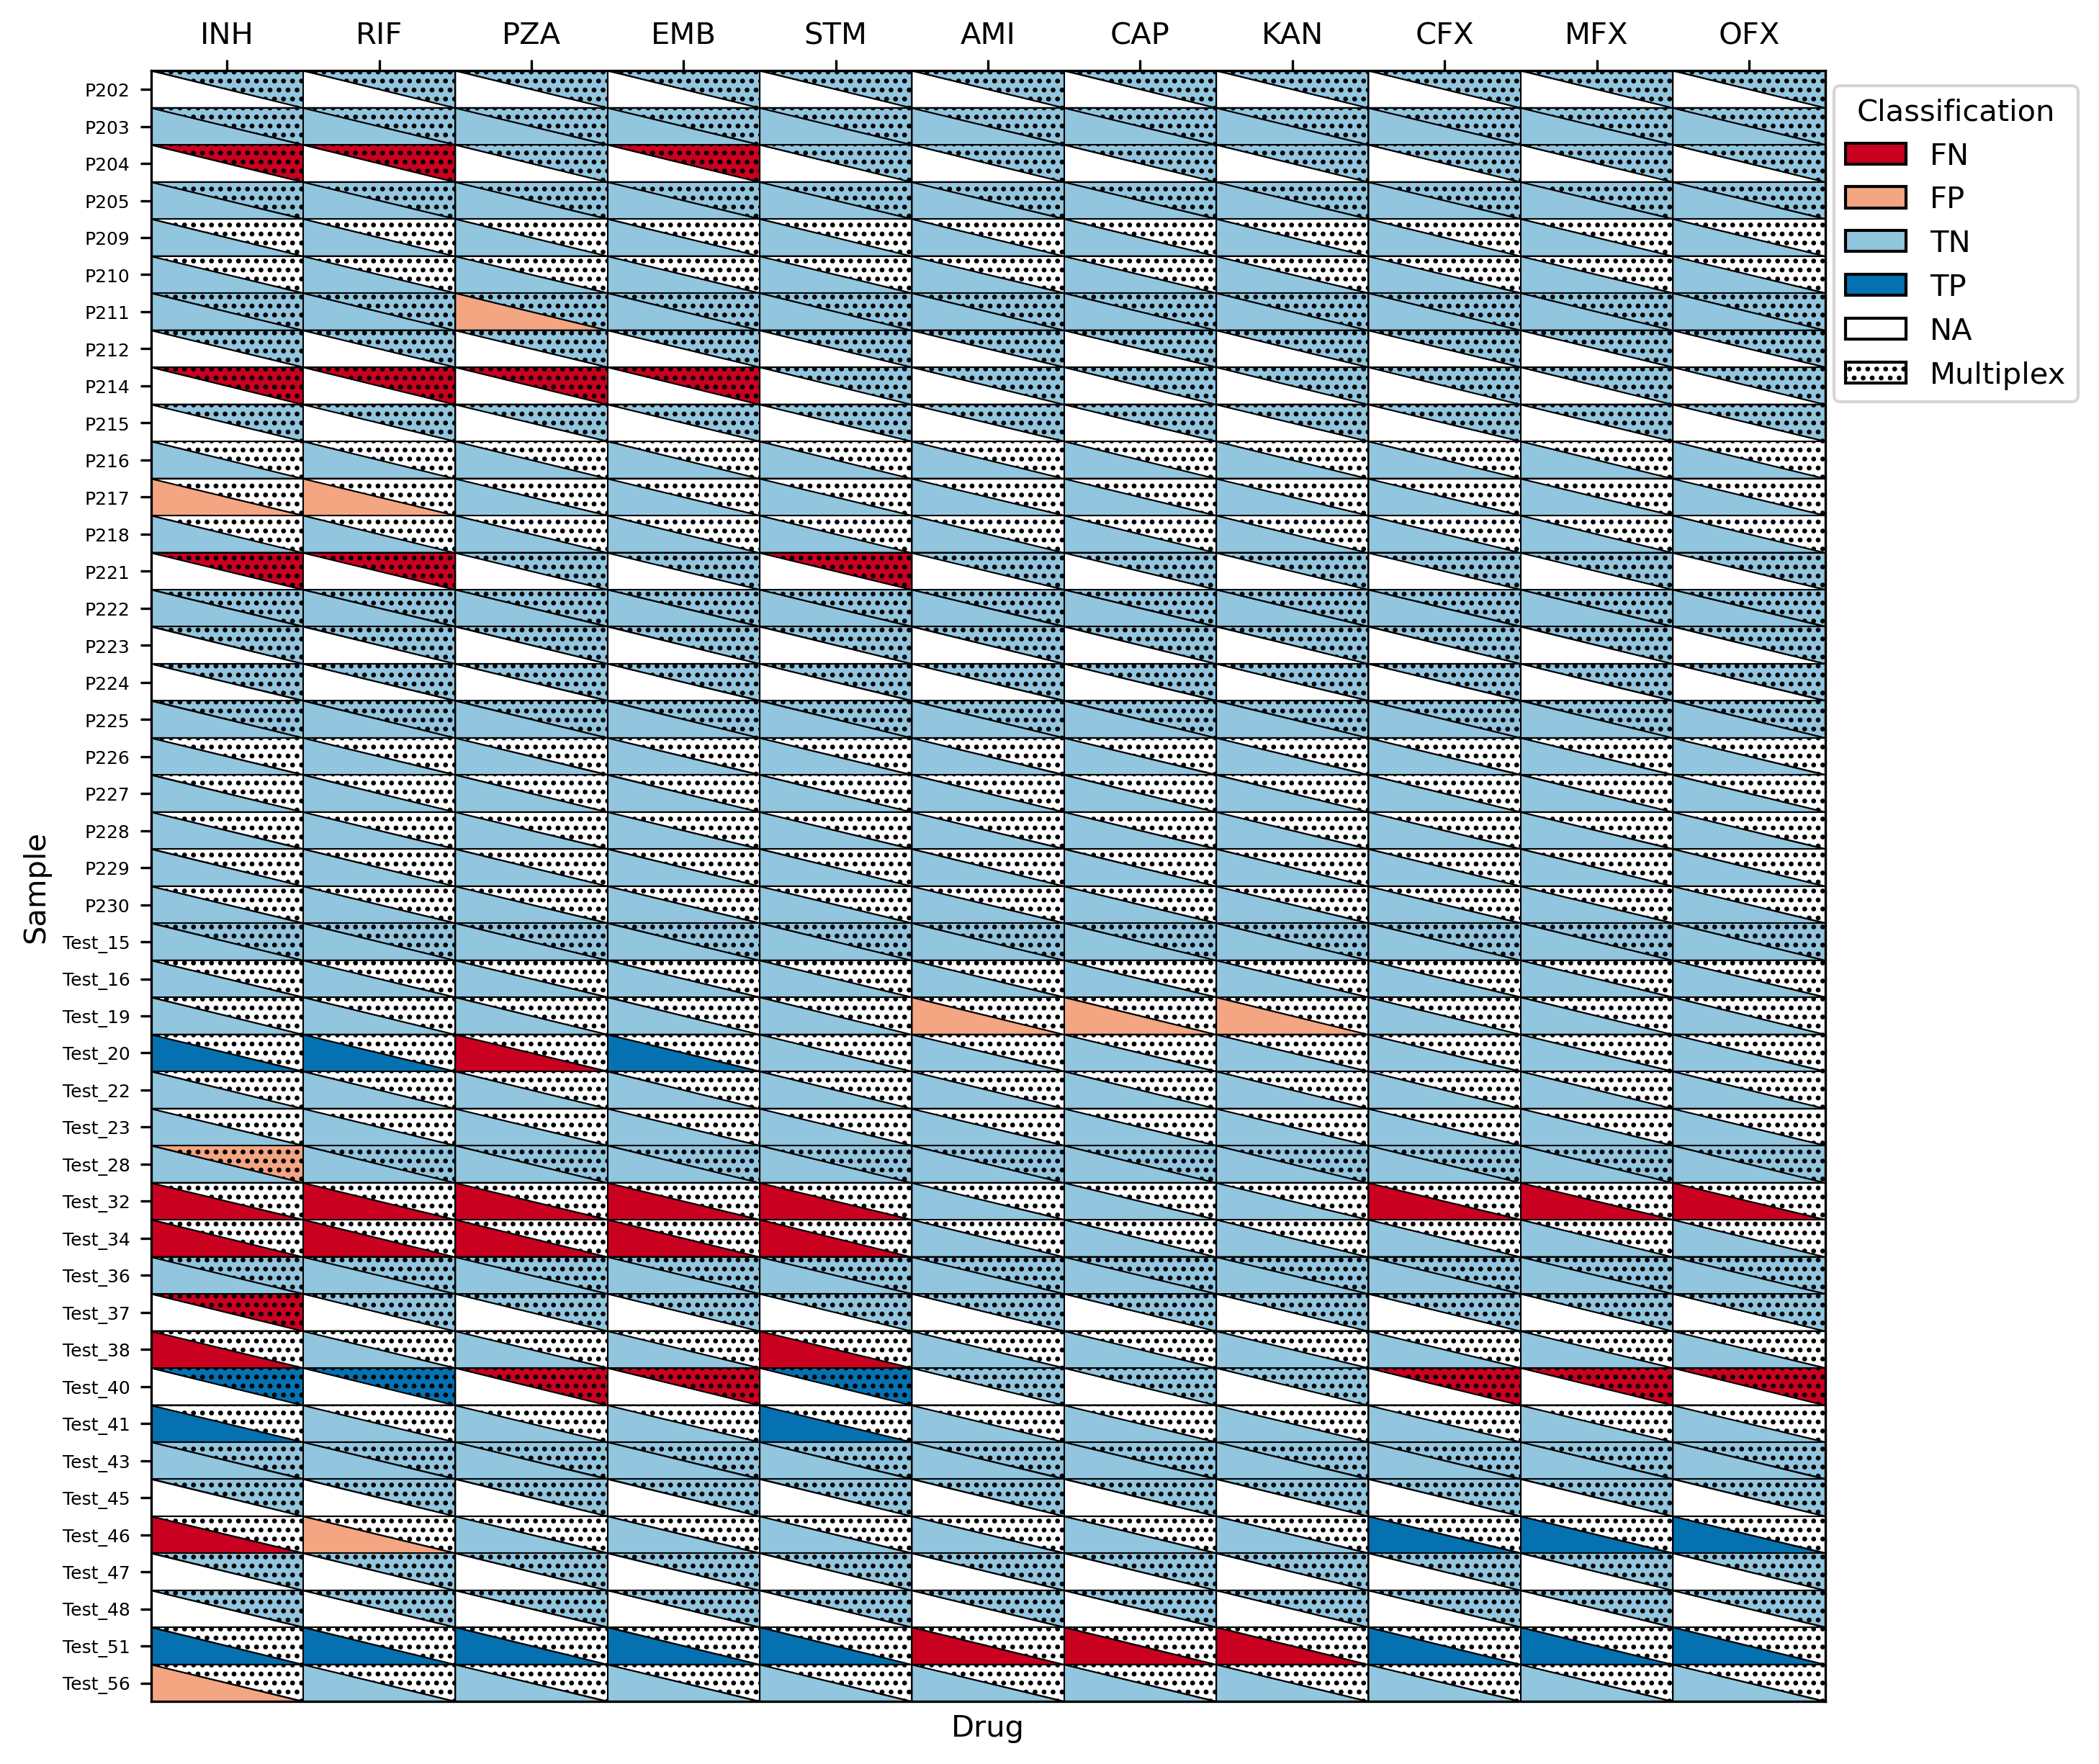

In [39]:
rows, cols = X_mono.shape
x = np.arange(cols + 1)
y = np.arange(rows + 1)
xs, ys = np.meshgrid(x, y)

C_mono = add_row_col_padding(X_mono)[:-1, :-1].ravel()
C_multi = add_row_col_padding(X_multi)[:-1, :-1].ravel()

triangles1 = np.array([(i + j*(cols+1), i+1 + j*(cols+1), i + (j+1)*(cols+1)) for j in range(rows) for i in range(cols)])
triangles2 = np.array([(i+1 + j*(cols+1), i+1 + (j+1)*(cols+1), i + (j+1)*(cols+1)) for j in range(rows) for i in range(cols)])

t1 = Triangulation(xs.ravel(), ys.ravel(), triangles1)
t2 = Triangulation(xs.ravel(), ys.ravel(), triangles2)

fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

img1 = ax.tripcolor(t1,  C_mono, cmap=cmap, vmin=0, vmax=len(colors), edgecolors='k', linewidth=0.5,)
hatch = "...."
img2 = ax.tripcolor(t2,  C_multi, cmap=cmap, vmin=0, vmax=len(colors), edgecolors='k', linewidth=0.5, hatch=hatch)
plt.xlim(x[0], x[-1])
plt.ylim(y[0], y[-1])
ax.set(ylabel="Sample", xlabel="Drug")

patches = []
for k, v in classmap.items():
    patches.append(mpatches.Patch(facecolor=colors[v], label=k, edgecolor="black"))
patches.append(mpatches.Patch(facecolor=colors[-1], label="Multiplex", edgecolor="black", hatch=hatch))
plt.legend(handles=patches, title="Classification", bbox_to_anchor=(1.16, 1), loc="upper right")

drug_labels = [drug2abbrev[d] for d in drugs]
_ = ax.set_xticks(np.arange(len(drugs))+0.5, labels=drug_labels)
ax.xaxis.tick_top()
_ = ax.set_yticks(np.arange(len(samples))+0.5, labels=sorted(samples, reverse=True), size=6)

Creating tables of Sensitivity and Specificity

In [31]:
class Prediction(Enum):
    Resistant = "R"
    Susceptible = "S"
    MinorResistance = "r"
    Unknown = "U"
    Failed = "F"

    def __str__(self) -> str:
        return self.value


class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value


class Classifier:
    def __init__(
        self,
        minor_is_susceptible: bool = False,
        unknown_is_resistant: bool = False,
        failed_is_resistant: bool = False,
    ):
        self.minor_is_susceptible = minor_is_susceptible
        self.unknown_is_resistant = unknown_is_resistant
        self.failed_is_resistant = failed_is_resistant
        self.susceptible = {Prediction.Susceptible}
        self.resistant = {Prediction.Resistant}
        if self.minor_is_susceptible:
            self.susceptible.add(Prediction.MinorResistance)
        else:
            self.resistant.add(Prediction.MinorResistance)

        if self.unknown_is_resistant:
            self.resistant.add(Prediction.Unknown)
        else:
            self.susceptible.add(Prediction.Unknown)

        if self.failed_is_resistant:
            self.resistant.add(Prediction.Failed)
        else:
            self.susceptible.add(Prediction.Failed)

    def from_predictions(
        self, y_true: Prediction, y_pred: Prediction
    ) -> Classification:
        if y_true in self.susceptible:
            expected_susceptible = True
        elif y_true in self.resistant:
            expected_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_true} calls yet")

        if y_pred in self.susceptible:
            called_susceptible = True
        elif y_pred in self.resistant:
            called_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_pred} calls yet")

        if expected_susceptible and called_susceptible:
            return Classification.TrueNegative
        elif expected_susceptible and not called_susceptible:
            return Classification.FalsePositive
        elif not expected_susceptible and not called_susceptible:
            return Classification.TruePositive
        else:
            return Classification.FalseNegative



@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> Tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def num_positive(self) -> int:
        """Number of TPs and FNs - i.e. actual condition positive"""
        return self.tp + self.fn

    def num_negative(self) -> int:
        """Number of TNs and FPs - i.e. actual condition negative"""
        return self.tn + self.fp

    def ppv(self) -> Tuple[float, float, float]:
        """Also known as precision"""
        try:
            ppv = self.tp / (self.tp + self.fp)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fp)
            return ppv, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def npv(self) -> Tuple[float, float, float]:
        """Negative predictive value"""
        try:
            npv = self.tn / (self.tn + self.fn)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fn)
            return npv, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def sensitivity(self) -> float:
        """Also known as recall and true positive rate (TPR)"""
        try:
            return self.tp / self.num_positive()
        except ZeroDivisionError:
            return None

    def specificity(self) -> float:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            return self.tn / self.num_negative()
        except ZeroDivisionError:
            return None

    def fnr(self) -> Tuple[float, float, float]:
        """False negative rate or VME (very major error rate)"""
        try:
            fnr = self.fn / self.num_positive()
            lwr_bound, upr_bound = confidence_interval(n_s=self.fn, n_f=self.tp)
            return fnr, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def fpr(self) -> Tuple[float, float, float]:
        """False positive rate or ME (major error rate)"""
        try:
            fpr = self.fp / self.num_negative()
            lwr_bound, upr_bound = confidence_interval(n_s=self.fp, n_f=self.tn)
            return fpr, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def f_score(self, beta: float = 1.0) -> float:
        """Harmonic mean of precision and recall.
        When beta is set to 0, you get precision. When beta is set to 1, you get the
        unweighted F-score which is the harmonic mean of precision and recall. Setting
        beta to 2 weighs recall twice as much as precision. Setting beta to 0.5 weighs
        precision twice as much as recall.
        """
        ppv = self.precision()
        tpr = self.recall()
        if ppv is None or tpr is None:
            return None
        beta2 = beta ** 2

        return ((beta2 + 1) * ppv * tpr) / ((beta2 * ppv) + tpr)

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)


def confidence_interval(n_s: int, n_f: int, conf: float = CONF) -> Tuple[float, float]:
    """Calculate the Wilson score interval.
    Equation take from https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
    n_s: Number of successes or, in the case of confusion matrix statistics, the numerator
    n_f: Number of failures or, in the case of confusion matrix statistics, the denominator minus the numerator
    conf: the confidence level. i.e. 0.95 is 95% confidence
    """
    n = n_f + n_s
    z = stats.norm.ppf(1 - (1 - conf) / 2)  # two-sided
    z2 = z ** 2
    nz2 = n + z2
    A = (n_s + (0.5 * z2)) / nz2
    B = z / nz2
    C = sqrt(((n_s * n_f) / n) + (z2 / 4))
    CI = B * C
    return A - CI, A + CI


def round_up_to_base(x, base=10):
    return int(x + (base - x) % base)


def round_down_to_base(x, base=10):
    return int(x - (x % base))

In [32]:
ill_sputum

,name,technology,source,is_multiplex,drug,prediction
0,P224,illumina,sputum,False,Ofloxacin,S
1,P224,illumina,sputum,False,Moxifloxacin,S
2,P224,illumina,sputum,False,Isoniazid,S
3,P224,illumina,sputum,False,Kanamycin,S
4,P224,illumina,sputum,False,Ethambutol,S
...,...,...,...,...,...,...
776,P217,illumina,sputum,False,Ciprofloxacin,S
777,P217,illumina,sputum,False,Pyrazinamide,S
778,P217,illumina,sputum,False,Rifampicin,S
779,P217,illumina,sputum,False,Amikacin,S


In [33]:
ignore_drugs = set()
pheno_clf = []
minor_is_susceptible = False
unknown_is_resistant = False
failed_is_resistant = False
classifier = Classifier(unknown_is_resistant=unknown_is_resistant, minor_is_susceptible=minor_is_susceptible)

for i, s in enumerate(sorted(samples)):
    if s not in ill_sputum_names:
        continue
    for j, d in enumerate(drugs):
        if d in ignore_drugs:
            continue
            
        expected = Prediction(culture_df.at[(s, d), "prediction"])
        actual = Prediction(ill_sputum.query("name==@s and drug==@d")["prediction"].iloc[0])
   
        clf = classifier.from_predictions(expected, actual)

        pheno_clf.append((s, d, str(clf)))

In [34]:
ill_sputum_clf = pd.DataFrame(
    pheno_clf, columns=["name", "drug", "classification"]
)

In [35]:
ill_pheno_cms = defaultdict()

PHENO_DRUGS = set()

for drug in set(ill_sputum_clf["drug"]):
    s = ill_sputum_clf.query("drug == @drug").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    ill_pheno_cms[drug] = cm
    PHENO_DRUGS.add(drug)
    
PHENO_DRUGS = sorted(PHENO_DRUGS)

In [36]:
metrics = []
for drug, cm in ill_pheno_cms.items():
        #         sensitivity = cm.sensitivity()
        #         specificity = cm.specificity()
    ppv = cm.ppv()[0]
    npv = cm.npv()[0]
    vme = cm.fnr()[0]
    me = cm.fpr()[0]
    metrics.append((drug, ppv, npv, vme, me))

summary_cols = [
    "drug",
    "PPV",
    "NPV",
    "FNR",
    "FPR",
]

ill_summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug"], var_name="metric")

In [37]:
# ill_counts = ill_sputum_clf.groupby(["drug", "classification"])["name"].count()
ill_table = ill_summary.set_index(["drug", "metric"])["value"].unstack().reset_index()

for clf in ["TP", "FP", "FN", "TN"]:
    ill_table[clf] = 0

for i, row in ill_table.iterrows():
    ix = row["drug"]
    cm = ill_pheno_cms[ix]
    ill_table.at[i, "TP"] = cm.tp
    ill_table.at[i, "FP"] = cm.fp
    ill_table.at[i, "TN"] = cm.tn
    ill_table.at[i, "FN"] = cm.fn
    
for k in ["drug"]:
    ill_table[k] = ill_table[k].str.capitalize()

ill_table.fillna("-", inplace=True)
summary_cols = ["drug", "PPV", "NPV", "FNR", "FPR", "TP", "TN", "FN", "FP"]
ill_table = ill_table[summary_cols]

In [38]:
rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1]*100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in ill_table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    npv = cm.npv()
    ppv = cm.ppv()
    vme = cm.fnr()
    me = cm.fpr()
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (
            row["drug"].capitalize(),
            fn_str,
            fp_str,
            ci_str(vme),
            ci_str(me),
            ci_str(ppv),
            ci_str(npv),
        )
    )
pretty_cols = [
    "Drug",
    "FN(R)",
    "FP(S)",
    "FNR(95% CI)",
    "FPR(95% CI)",
    "PPV(95% CI)",
    "NPV(95% CI)",
]
ill_table = pd.DataFrame(rows, columns=pretty_cols)
ill_table

,Drug,FN(R),FP(S),FNR(95% CI),FPR(95% CI),PPV(95% CI),NPV(95% CI)
0,Amikacin,0(1),1(42),0.0% (0.0-79.3%),2.4% (0.4-12.3%),50.0% (9.5-90.5%),100.0% (91.4-100.0%)
1,Capreomycin,0(1),1(42),0.0% (0.0-79.3%),2.4% (0.4-12.3%),50.0% (9.5-90.5%),100.0% (91.4-100.0%)
2,Ciprofloxacin,4(4),1(39),100.0% (51.0-100.0%),2.6% (0.5-13.2%),0.0% (0.0-79.3%),90.5% (77.9-96.2%)
3,Ethambutol,4(7),2(36),57.1% (25.0-84.2%),5.6% (1.5-18.1%),60.0% (23.1-88.2%),89.5% (75.9-95.8%)
4,Isoniazid,6(12),2(31),50.0% (25.4-74.6%),6.5% (1.8-20.7%),75.0% (40.9-92.9%),82.9% (67.3-91.9%)
5,Kanamycin,0(1),1(42),0.0% (0.0-79.3%),2.4% (0.4-12.3%),50.0% (9.5-90.5%),100.0% (91.4-100.0%)
6,Moxifloxacin,4(4),1(39),100.0% (51.0-100.0%),2.6% (0.5-13.2%),0.0% (0.0-79.3%),90.5% (77.9-96.2%)
7,Ofloxacin,4(4),1(39),100.0% (51.0-100.0%),2.6% (0.5-13.2%),0.0% (0.0-79.3%),90.5% (77.9-96.2%)
8,Pyrazinamide,4(6),1(37),66.7% (30.0-90.3%),2.7% (0.5-13.8%),66.7% (20.8-93.9%),90.0% (76.9-96.0%)
9,Rifampicin,7(8),6(35),87.5% (52.9-97.8%),17.1% (8.1-32.7%),14.3% (2.6-51.3%),80.6% (65.0-90.2%)


In [39]:
ignore_drugs = set()
pheno_clf = []
minor_is_susceptible = False
unknown_is_resistant = False
failed_is_resistant = False
classifier = Classifier(unknown_is_resistant=unknown_is_resistant, minor_is_susceptible=minor_is_susceptible)

for i, s in enumerate(sorted(samples)):
    for j, d in enumerate(drugs):
        if d in ignore_drugs:
            continue

        expected = Prediction(culture_df.at[(s, d), "prediction"])
        
        multi_actual = ont_sputum["prediction"].get((s, True, d), default=None)
        if multi_actual is not None:
            clf = classifier.from_predictions(expected, Prediction(multi_actual))
            pheno_clf.append((s, d, "multiplex", str(clf)))
            
        mono_actual = ont_sputum["prediction"].get((s, False, d), default=None)
        if mono_actual is not None:
            clf = classifier.from_predictions(expected, Prediction(mono_actual))
            pheno_clf.append((s, d, "monoplex", str(clf)))

In [40]:
ont_sputum_clf = pd.DataFrame(
    pheno_clf, columns=["name", "drug", "strategy", "classification"]
)

In [41]:
ont_pheno_cms = defaultdict()

PHENO_DRUGS = set()

for drug, is_multi in product(set(ont_sputum_clf["drug"]), ["multiplex", "monoplex"]):
    s = ont_sputum_clf.query("drug == @drug and strategy == @is_multi").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    ont_pheno_cms[(drug, is_multi)] = cm
    PHENO_DRUGS.add(drug)
    
PHENO_DRUGS = sorted(PHENO_DRUGS)

In [42]:
metrics = []
for (drug, strat), cm in ont_pheno_cms.items():
        #         sensitivity = cm.sensitivity()
        #         specificity = cm.specificity()
    ppv = cm.ppv()[0]
    npv = cm.npv()[0]
    vme = cm.fnr()[0]
    me = cm.fpr()[0]
    metrics.append((drug, strat, ppv, npv, vme, me))

summary_cols = [
    "drug",
    "strategy",
    "PPV",
    "NPV",
    "FNR",
    "FPR",
]

ont_summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "strategy"], var_name="metric")

In [43]:
# ill_counts = ill_sputum_clf.groupby(["drug", "classification"])["name"].count()
ont_table = ont_summary.set_index(["drug", "strategy", "metric"])["value"].unstack().reset_index()

for clf in ["TP", "FP", "FN", "TN"]:
    ont_table[clf] = 0

for i, row in ont_table.iterrows():
    ix = (row["drug"], row["strategy"])
    cm = ont_pheno_cms[ix]
    ont_table.at[i, "TP"] = cm.tp
    ont_table.at[i, "FP"] = cm.fp
    ont_table.at[i, "TN"] = cm.tn
    ont_table.at[i, "FN"] = cm.fn
    
for k in ["drug", "strategy"]:
    ont_table[k] = ont_table[k].str.capitalize()

ont_table.fillna("-", inplace=True)
summary_cols = ["drug", "strategy", "PPV", "NPV", "FNR", "FPR", "TP", "TN", "FN", "FP"]
ont_table = ont_table[summary_cols]

In [44]:
rows = []

for i, row in ont_table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    npv = cm.npv()
    ppv = cm.ppv()
    vme = cm.fnr()
    me = cm.fpr()
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (
            row["drug"].capitalize(),
            row["strategy"].capitalize(),
            fn_str,
            fp_str,
            ci_str(vme),
            ci_str(me),
            ci_str(ppv),
            ci_str(npv),
        )
    )
pretty_cols = [
    "Drug",
    "Strategy",
    "FN(R)",
    "FP(S)",
    "FNR(95% CI)",
    "FPR(95% CI)",
    "PPV(95% CI)",
    "NPV(95% CI)",
]
ont_table = pd.DataFrame(rows, columns=pretty_cols)
ont_table

,Drug,Strategy,FN(R),FP(S),FNR(95% CI),FPR(95% CI),PPV(95% CI),NPV(95% CI)
0,Amikacin,Monoplex,1(1),1(30),100.0% (20.7-100.0%),3.3% (0.6-16.7%),0.0% (0.0-79.3%),96.7% (83.3-99.4%)
1,Amikacin,Multiplex,0(0),0(22),-,0.0% (0.0-14.9%),-,100.0% (85.1-100.0%)
2,Capreomycin,Monoplex,1(1),1(30),100.0% (20.7-100.0%),3.3% (0.6-16.7%),0.0% (0.0-79.3%),96.7% (83.3-99.4%)
3,Capreomycin,Multiplex,0(0),0(22),-,0.0% (0.0-14.9%),-,100.0% (85.1-100.0%)
4,Ciprofloxacin,Monoplex,1(3),0(28),33.3% (6.1-79.2%),0.0% (0.0-12.1%),100.0% (34.2-100.0%),96.6% (82.8-99.4%)
5,Ciprofloxacin,Multiplex,1(1),0(21),100.0% (20.7-100.0%),0.0% (0.0-15.5%),-,95.5% (78.2-99.2%)
6,Ethambutol,Monoplex,2(4),0(27),50.0% (15.0-85.0%),0.0% (0.0-12.5%),100.0% (34.2-100.0%),93.1% (78.0-98.1%)
7,Ethambutol,Multiplex,3(3),0(19),100.0% (43.9-100.0%),0.0% (0.0-16.8%),-,86.4% (66.7-95.3%)
8,Isoniazid,Monoplex,4(7),2(24),57.1% (25.0-84.2%),8.3% (2.3-25.8%),60.0% (23.1-88.2%),84.6% (66.5-93.8%)
9,Isoniazid,Multiplex,4(5),1(17),80.0% (37.6-96.4%),5.9% (1.0-27.0%),50.0% (9.5-90.5%),80.0% (58.4-91.9%)


In [45]:
covclf_df = pd.DataFrame(cov_clf, columns=["drug", "coverage", "classification", "name", "source", "technology", "is_multiplex"])

In [46]:
covclf_df = covclf_df.loc[~covclf_df["coverage"].isna()]

In [47]:
covclf_df

,drug,coverage,classification,name,source,technology,is_multiplex
0,Isoniazid,0.2,TN,P202,sputum,illumina,False
1,Rifampicin,0.2,TN,P202,sputum,illumina,False
2,Pyrazinamide,0.2,TN,P202,sputum,illumina,False
3,Ethambutol,0.2,TN,P202,sputum,illumina,False
4,Streptomycin,0.2,TN,P202,sputum,illumina,False
...,...,...,...,...,...,...,...
1431,Capreomycin,1.9,TN,Test_56,sputum,nanopore,False
1433,Kanamycin,1.9,TN,Test_56,sputum,nanopore,False
1435,Ciprofloxacin,1.9,TN,Test_56,sputum,nanopore,False
1437,Moxifloxacin,1.9,TN,Test_56,sputum,nanopore,False


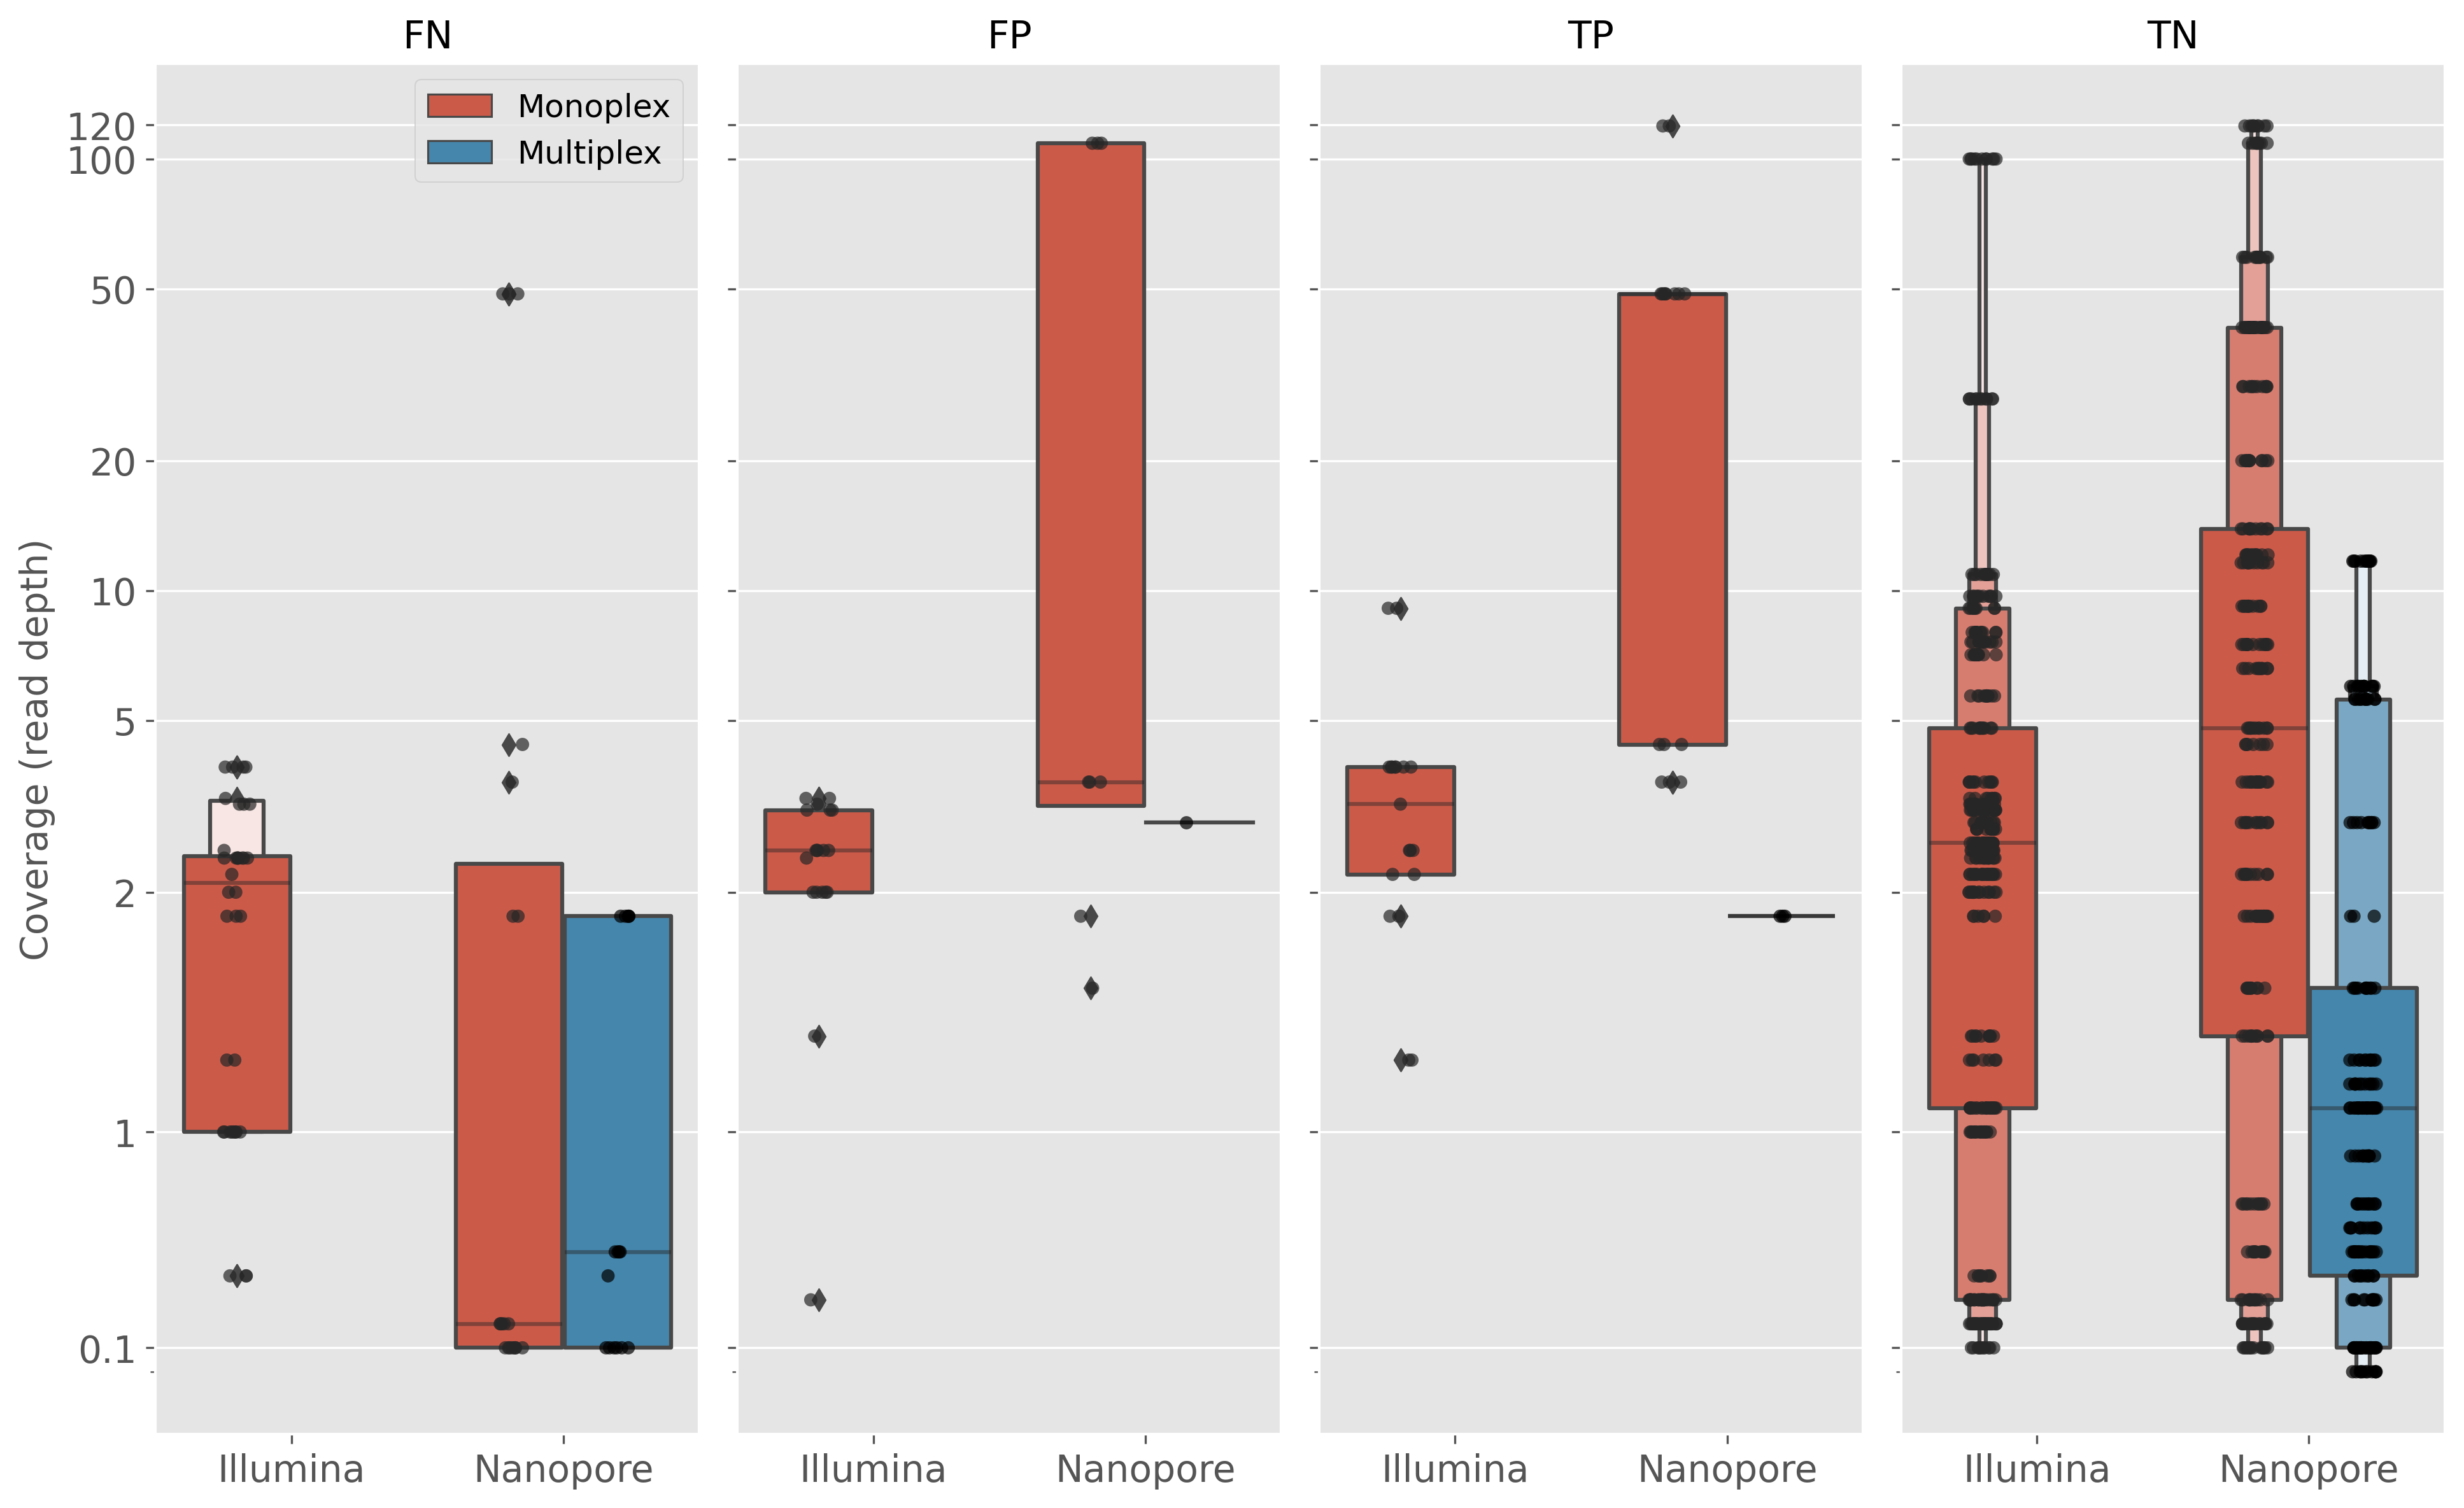

In [48]:
plt.style.use("ggplot")
data = covclf_df.query("source=='sputum'")
lsize = 14  # label size
x = "technology"
y = "coverage"
hue = "is_multiplex"
order = ["FN", "FP", "TP", "TN"]
fig, axes = plt.subplots(figsize=(13, 8), dpi=300, ncols=len(order), sharey=True)
for i, (clf, ax) in enumerate(zip(order, axes.flatten())):
    sns.boxenplot(data=data.query("classification==@clf"), x=x, y=y, hue=hue, ax=ax, )#boxprops=dict(facecolor="none"), fliersize=0)
    sns.stripplot(data=data.query("classification==@clf"), x=x, y=y, hue=hue, ax=ax, dodge=True, alpha=0.7, color="black")
    ax.set_yscale("symlog")
    ticks = [0.1, 1, 2, 5, 10, 20, 50, 100, 120]
    ax.set_yticks(ticks)
    _ = ax.set_yticklabels(ticks)
    ax.set_xlabel("")
    if i == 0:
            handles, labels = ax.get_legend_handles_labels()
            labels = ["Multiplex" if l == "True" else "Monoplex" for l in labels]
            unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            ax.legend(*zip(*unique), fontsize="12")
    else:
        ax.legend().remove()
#     ax.set_ylim((-0.1, 150))
    ylabel = "" if i > 0 else "Coverage (read depth)"
    _ = ax.set_ylabel(ylabel, fontsize="14")
    labels = []
    for label in ax.get_xticklabels():
        label.set_fontsize(lsize)
        label.set_text(label.get_text().capitalize())
        labels.append(label)
    ax.set_xticklabels(labels)
    ax.yaxis.set_tick_params(labelsize=lsize)
    
    ax.set_title(clf)

plt.tight_layout()

# Combined results figure

In [49]:
lineage_df = pd.read_csv("../../results/lineages.csv").query("name in @final_samples and smear != '-'")

In [50]:
lineage_df

,name,lineage,source,technology,smear,is_multiplex,species
0,P201,Unknown,sputum,nanopore,+,True,Mycobacterium_tuberculosis
1,P202,1.1.2,sputum,nanopore,+,True,Mycobacterium_tuberculosis
2,P203,Unknown,sputum,nanopore,+,True,Mycobacterium_tuberculosis
3,P203,4.1.2,sputum,nanopore,+,False,Mycobacterium_tuberculosis
4,P204,Unknown,sputum,nanopore,+,True,Unknown
...,...,...,...,...,...,...,...
195,Test_46,Unknown,sputum,illumina,++,False,Mycobacterium_tuberculosis
196,Test_47,4.3.4.1,sputum,illumina,+++,False,Mycobacterium_tuberculosis
197,Test_48,3,sputum,illumina,++,False,Mycobacterium_tuberculosis
199,Test_51,2.2.3,sputum,illumina,+++,False,Mycobacterium_tuberculosis


In [51]:
include_drugs = {"Isoniazid", "Rifampicin", "Ethambutol", "Pyrazinamide", "Moxifloxacin", "Streptomycin", "Amikacin"}

In [52]:
dst_df = df.query("drug in @include_drugs")

In [53]:
lineage_reference = {}
species_reference = {}
smear_reference = {}
for i, row in lineage_df.query("source=='culture'").iterrows():
    lineage_reference[row["name"]] = row["lineage"]
    species_reference[row["name"]] = row["species"]
    smear_reference[row["name"]] = row["smear"]

In [54]:
correct_major = []
correct_species = []
covgs = []
concs = []
for i, row in lineage_df.iterrows():
    lin = row["lineage"]
    sample = row["name"]
    reflin = lineage_reference.get(sample)
    refsp = species_reference.get(sample)
    
    cov = cov_df.at[(sample, row["source"], row["technology"], row["is_multiplex"]), "coverage"]
    covgs.append(cov)
    
    conc = concdf.at[sample, "conc"]
    concs.append(conc)
    
    species = row["species"]
    if species != "Mycobacterium_tuberculosis":
        lin = "Unknown"
    
    if reflin is None:
        assert refsp is None
        correct_major.append(None)
        correct_species.append(None)
    else:
        correct_major.append(reflin[0] == lin[0])
        correct_species.append(refsp == row["species"])

In [55]:
lineage_df["correct_lineage"] = correct_major
lineage_df["correct_species"] = correct_species
lineage_df["coverage"] = covgs
lineage_df["concentration"] = concs

In [56]:
lineage_df.query("source=='sputum'")

,name,lineage,source,technology,smear,is_multiplex,species,correct_lineage,correct_species,coverage,concentration
0,P201,Unknown,sputum,nanopore,+,True,Mycobacterium_tuberculosis,None,None,0.2,55.0
1,P202,1.1.2,sputum,nanopore,+,True,Mycobacterium_tuberculosis,True,True,6.0,49.4
2,P203,Unknown,sputum,nanopore,+,True,Mycobacterium_tuberculosis,False,True,1.1,114.0
3,P203,4.1.2,sputum,nanopore,+,False,Mycobacterium_tuberculosis,True,True,6.6,114.0
4,P204,Unknown,sputum,nanopore,+,True,Unknown,False,False,0.1,49.0
...,...,...,...,...,...,...,...,...,...,...,...
195,Test_46,Unknown,sputum,illumina,++,False,Mycobacterium_tuberculosis,False,True,3.2,21.8
196,Test_47,4.3.4.1,sputum,illumina,+++,False,Mycobacterium_tuberculosis,True,True,2.0,20.4
197,Test_48,3,sputum,illumina,++,False,Mycobacterium_tuberculosis,True,True,1.0,66.0
199,Test_51,2.2.3,sputum,illumina,+++,False,Mycobacterium_tuberculosis,True,True,3.9,84.4


In [57]:
dst_reference = {}
for i, row in dst_df.query("source=='culture'").iterrows():
    dst_reference[(row["name"], row["drug"])] = row["prediction"].upper()

In [58]:
dst_reference

{('P224', 'Moxifloxacin'): 'S',
 ('P224', 'Isoniazid'): 'S',
 ('P224', 'Ethambutol'): 'S',
 ('P224', 'Streptomycin'): 'S',
 ('P224', 'Pyrazinamide'): 'S',
 ('P224', 'Rifampicin'): 'S',
 ('P224', 'Amikacin'): 'S',
 ('P223', 'Moxifloxacin'): 'S',
 ('P223', 'Isoniazid'): 'S',
 ('P223', 'Ethambutol'): 'S',
 ('P223', 'Streptomycin'): 'S',
 ('P223', 'Pyrazinamide'): 'S',
 ('P223', 'Rifampicin'): 'S',
 ('P223', 'Amikacin'): 'S',
 ('Test_20', 'Moxifloxacin'): 'S',
 ('Test_20', 'Isoniazid'): 'R',
 ('Test_20', 'Ethambutol'): 'R',
 ('Test_20', 'Streptomycin'): 'S',
 ('Test_20', 'Pyrazinamide'): 'R',
 ('Test_20', 'Rifampicin'): 'R',
 ('Test_20', 'Amikacin'): 'S',
 ('Test_32', 'Moxifloxacin'): 'R',
 ('Test_32', 'Isoniazid'): 'R',
 ('Test_32', 'Ethambutol'): 'R',
 ('Test_32', 'Streptomycin'): 'R',
 ('Test_32', 'Pyrazinamide'): 'R',
 ('Test_32', 'Rifampicin'): 'R',
 ('Test_32', 'Amikacin'): 'S',
 ('Test_51', 'Moxifloxacin'): 'R',
 ('Test_51', 'Isoniazid'): 'R',
 ('Test_51', 'Ethambutol'): 'R',
 ('Tes

In [59]:
correct_dst = []
covgs = []
smears = []
concs = []
for i, row in dst_df.iterrows():
    sample = row["name"]
    drug = row["drug"]
    pred = row["prediction"].upper()
    
    cov = cov_df.at[(sample, row["source"], row["technology"], row["is_multiplex"]), "coverage"]
    covgs.append(cov)
    
    conc = concdf.at[sample, "conc"]
    concs.append(conc)
    
    smear = smear_reference.get(sample)
    smears.append(smear)
    
    true_pred = dst_reference.get((sample, drug))
    
    if true_pred is None:
        correct_dst.append(None)
    else:
        correct_dst.append(true_pred == pred)

In [60]:
dst_df["correct_dst"] = correct_dst
dst_df["coverage"] = covgs
dst_df["smear"] = smears
dst_df["concentration"] = concs

/var/folders/0g/3ywwrf6j2vjbp0r780dskt980000gn/T/ipykernel_70011/3520675749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dst_df["correct_dst"] = correct_dst
/var/folders/0g/3ywwrf6j2vjbp0r780dskt980000gn/T/ipykernel_70011/3520675749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dst_df["coverage"] = covgs
/var/folders/0g/3ywwrf6j2vjbp0r780dskt980000gn/T/ipykernel_70011/3520675749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [61]:
def legend_without_duplicate_labels(ax, title=""):
    handles, labels = ax.get_legend_handles_labels()
    labels = list(map(str.capitalize, labels))
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), title=title)

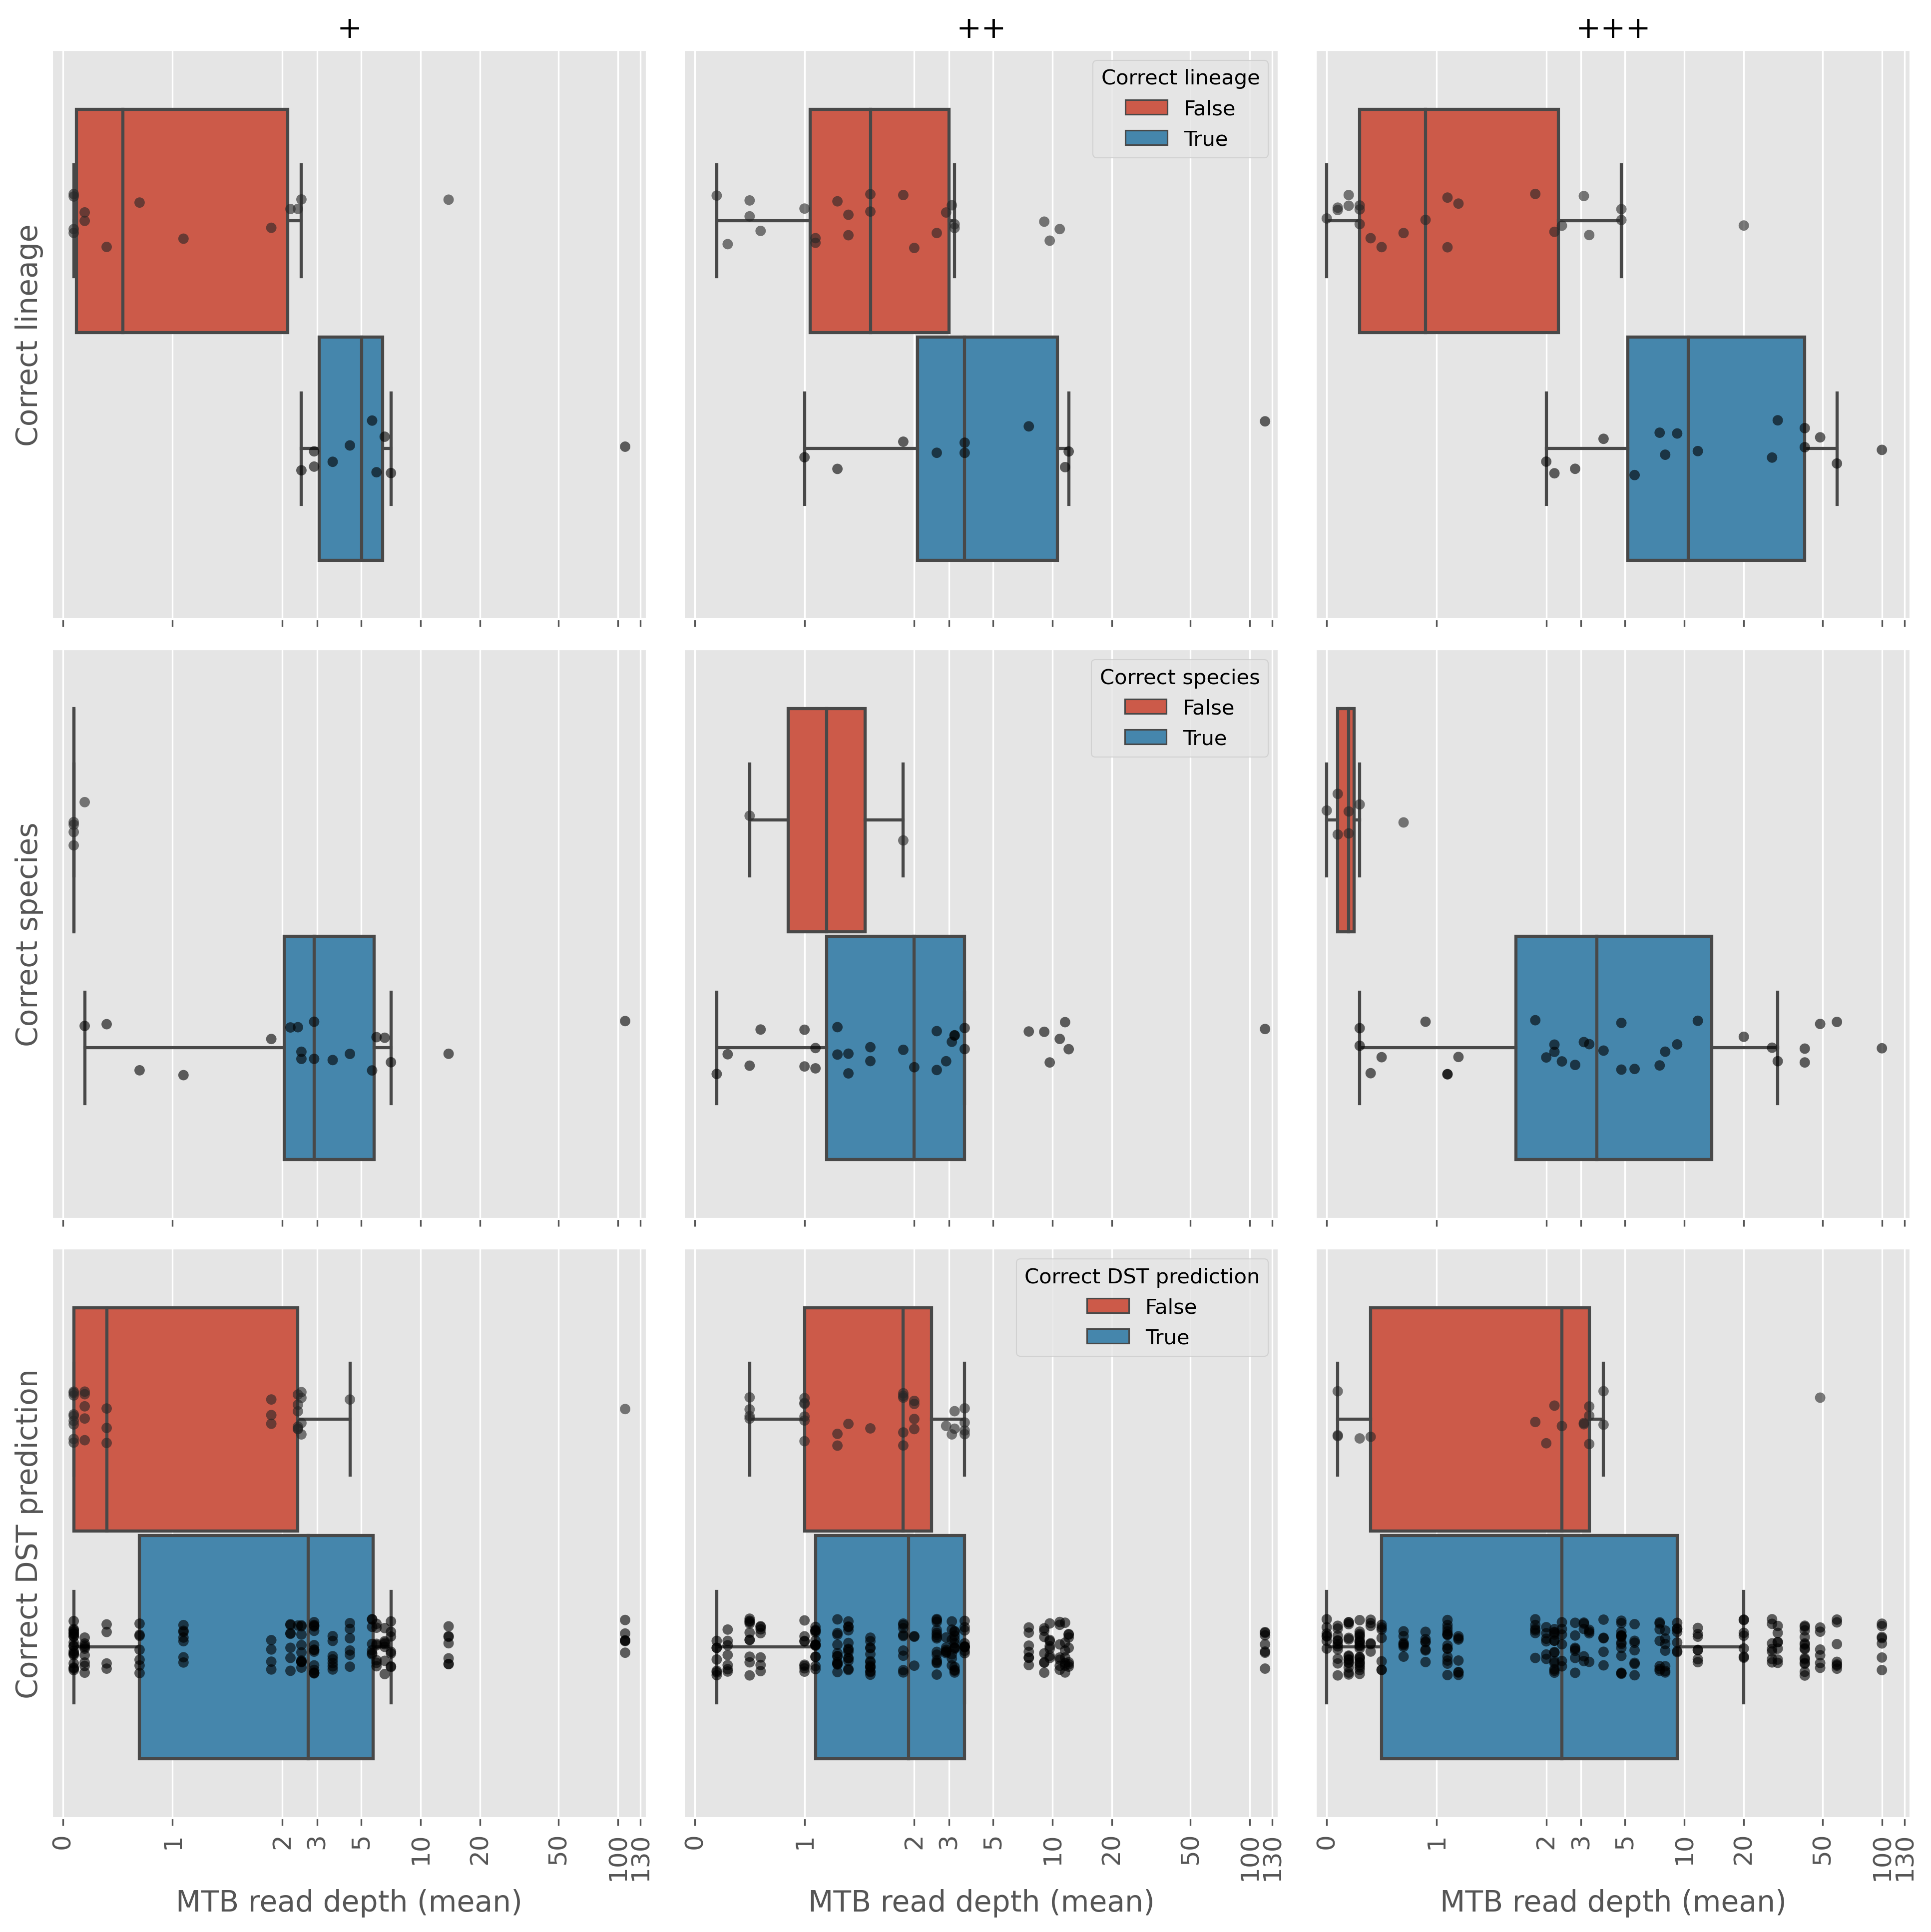

In [62]:
SMEARS = sorted(set(lineage_df["smear"]))
fig, axes = plt.subplots(nrows=3, ncols=len(SMEARS), dpi=300, figsize=(13, 13), sharey=False, sharex=True)
xticks = [0, 1, 2, 3, 5, 10, 20, 50, 100, 130]

# lineage
lineage_axes = axes[0]
x="coverage"
y="smear"
hue="correct_lineage"
ylab = "Correct lineage"
alpha = 0.6
hue_order = [False, True]
for i, s in enumerate(SMEARS):
    ax = lineage_axes[i]
    data = lineage_df.query("source == 'sputum' and smear==@s")
    sns.boxplot(data=data, x=x, y=y, hue=hue, fliersize=0, hue_order=hue_order, ax=ax)
    sns.stripplot(
        data=data, x=x, y=y, hue=hue, dodge=True, color="black", hue_order=hue_order, ax=ax, alpha=alpha
    )

    ax.set_xscale("symlog")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_xlim((-0.1, 140))
    if i == 1:
        legend_without_duplicate_labels(ax, ylab)
    else:
        ax.get_legend().remove()
    ax.set_xlabel("MTB read depth (mean)")
    ax.set_title(s)
    if i == 0:
        ax.set_ylabel(ylab, fontsize=14)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_yticklabels([])

# species
species_axes = axes[1]
hue="correct_species"
ylab = "Correct species"
for i, s in enumerate(SMEARS):
    ax = species_axes[i]
    data = lineage_df.query("source == 'sputum' and smear==@s")
    sns.boxplot(data=data, x=x, y=y, hue=hue, fliersize=0, hue_order=hue_order, ax=ax)
    sns.stripplot(
        data=data, x=x, y=y, hue=hue, dodge=True, color="black", hue_order=hue_order, ax=ax, alpha=alpha
    )
    
    ax.set_xscale("symlog")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_xlim((-0.1, 140))
    if i == 1:
        legend_without_duplicate_labels(ax, ylab)
    else:
        ax.get_legend().remove()
    ax.set_xlabel("MTB read depth (mean)")

    if i == 0:
        ax.set_ylabel(ylab, fontsize=14)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_yticklabels([])
    
# DST
dst_axes = axes[2]
hue="correct_dst"
ylab = "Correct DST prediction"
for i, s in enumerate(SMEARS):
    ax = dst_axes[i]
    data = dst_df.query("source == 'sputum' and smear==@s")
    sns.boxplot(data=data, x=x, y=y, hue=hue, fliersize=0, hue_order=hue_order, ax=ax)
    sns.stripplot(
        data=data, x=x, y=y, hue=hue, dodge=True, color="black", hue_order=hue_order, ax=ax, alpha=alpha
    )

    ax.set_xscale("symlog")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=90, fontsize=12)
    ax.set_xlim((-0.1, 140))
    if i == 1:
        legend_without_duplicate_labels(ax, ylab)
    else:
        ax.get_legend().remove()
    ax.set_xlabel("MTB read depth (mean)", fontsize=14)

    if i == 0:
        ax.set_ylabel(ylab, fontsize=14)
    else:
        ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_yticklabels([])
    
plt.tight_layout()

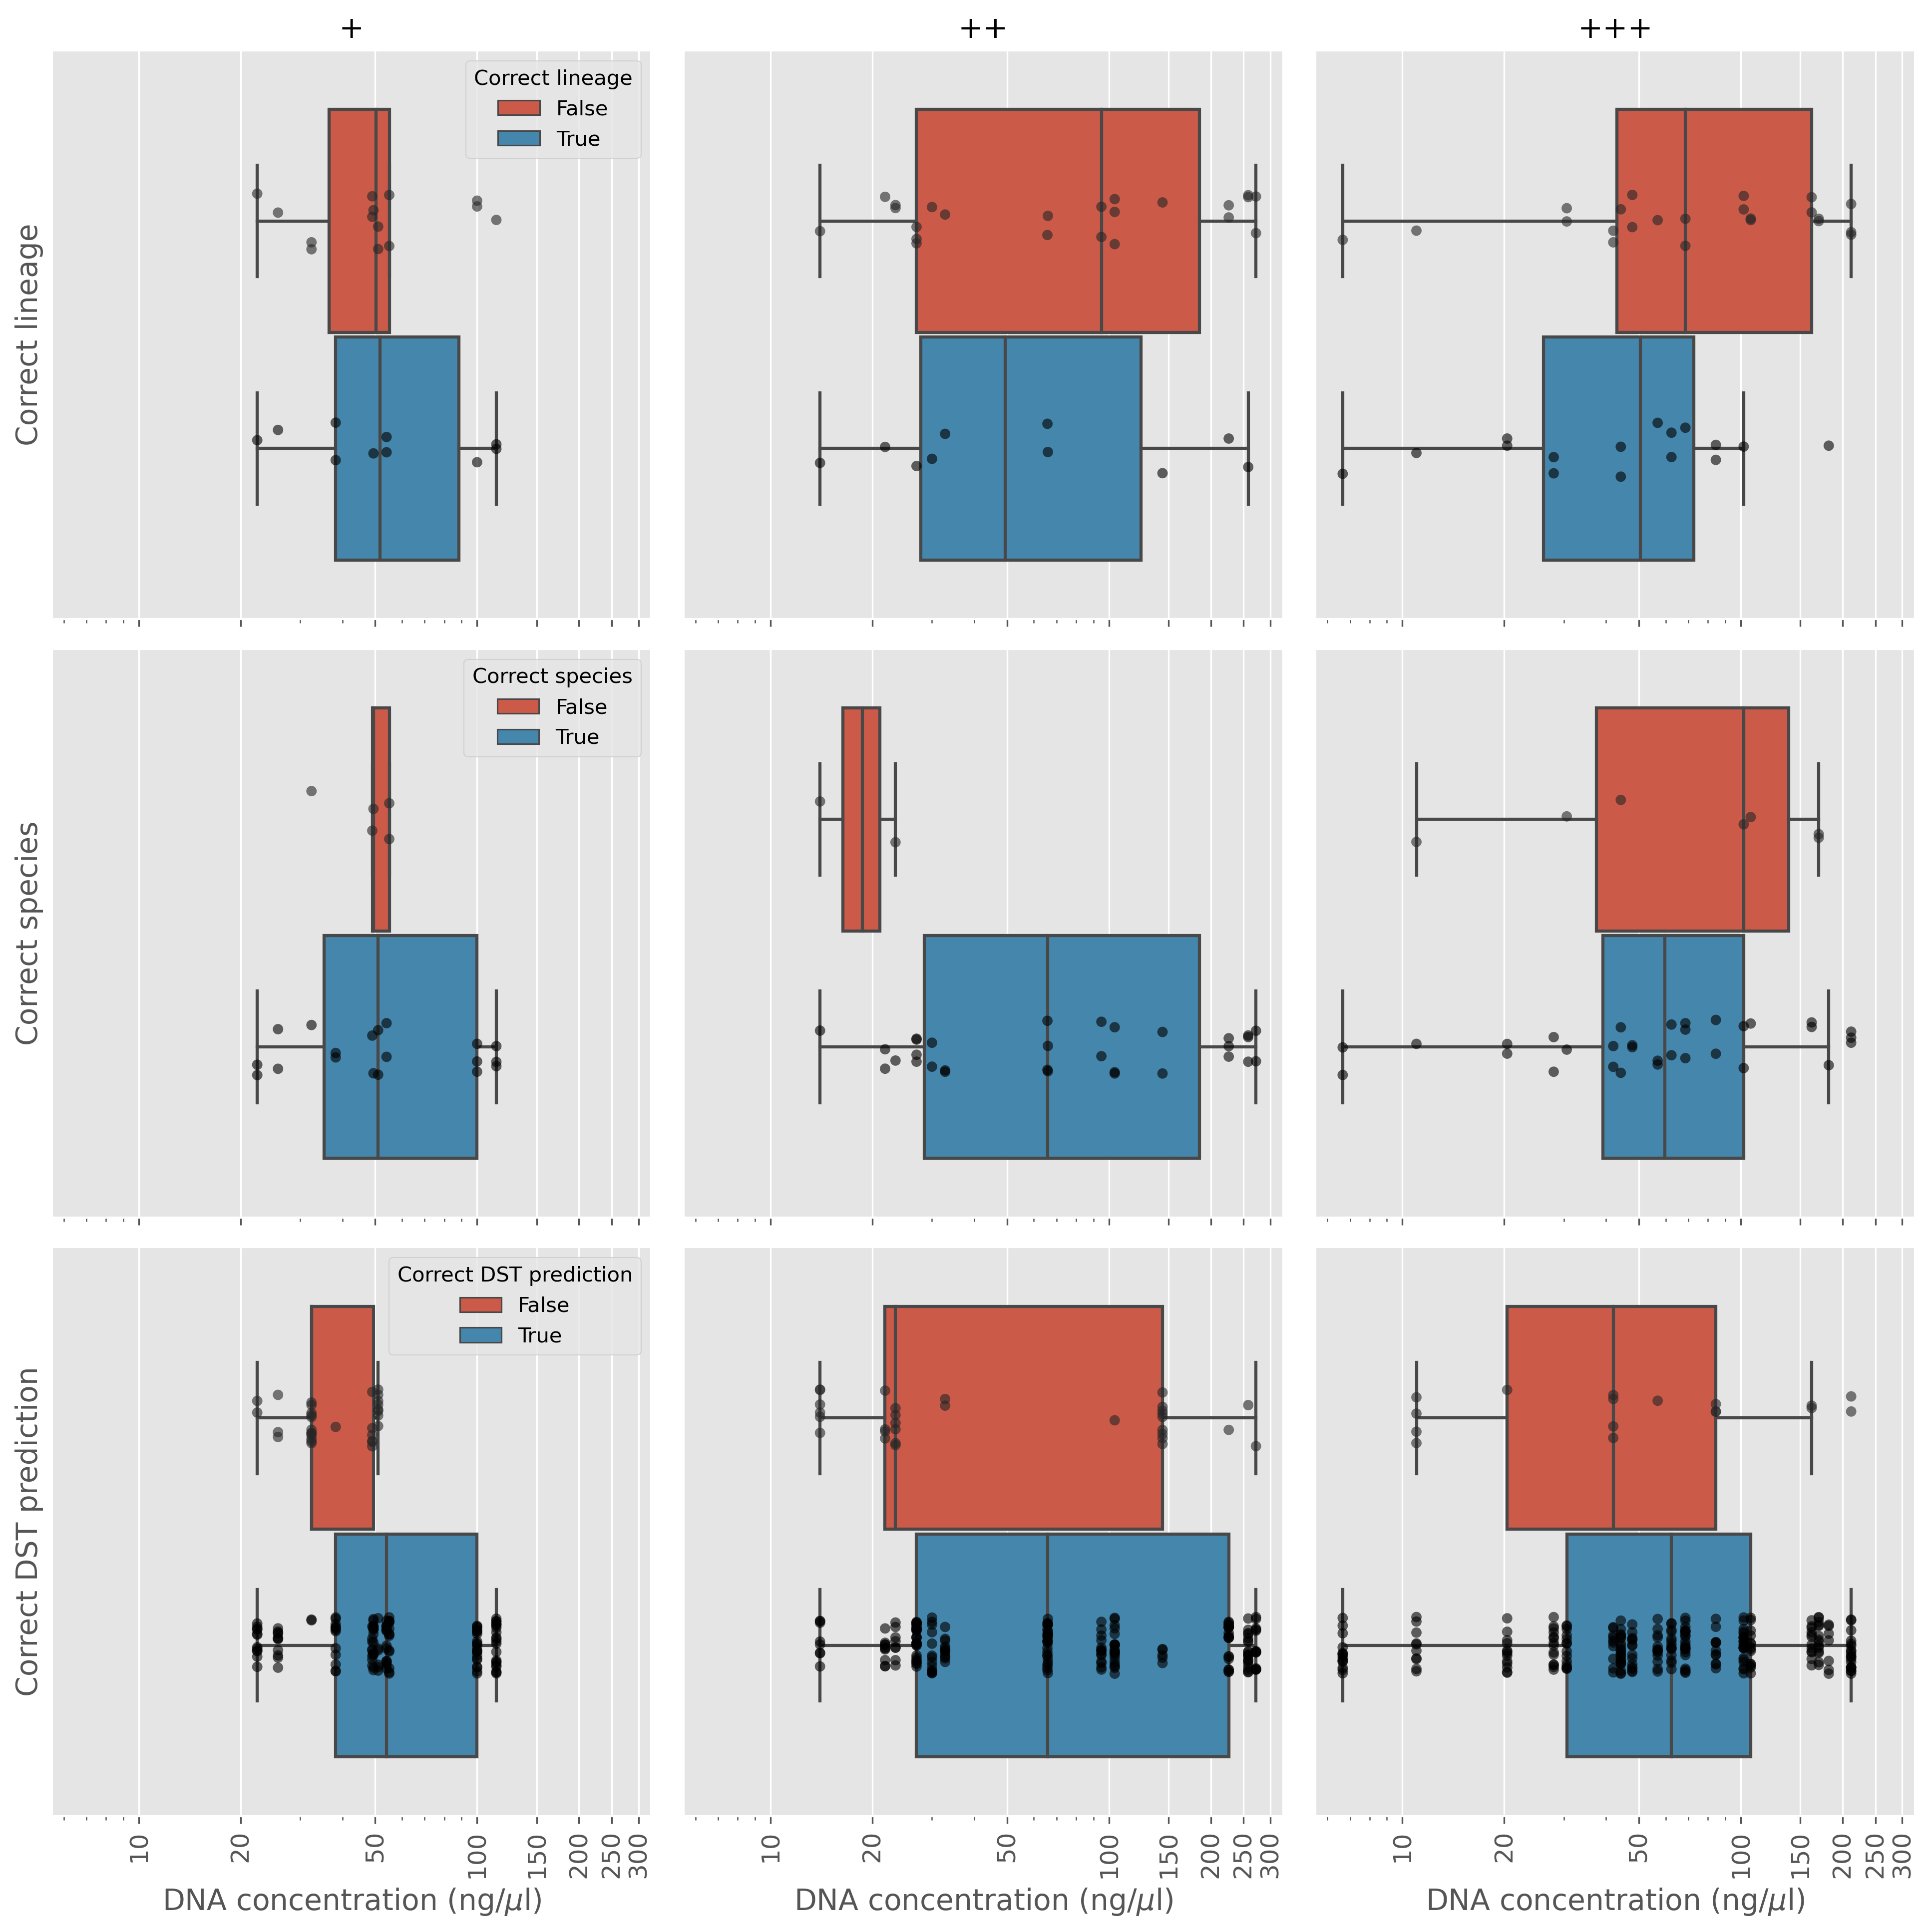

In [63]:
fig, axes = plt.subplots(nrows=3, ncols=len(SMEARS), dpi=300, figsize=(13, 13), sharey=False, sharex=True)
xticks = [10, 20, 50, 100, 150, 200, 250, 300]

# lineage
lineage_axes = axes[0]
x="concentration"
y="smear"
hue="correct_lineage"
ylab = "Correct lineage"
xlab = "DNA concentration (ng/$\mu$l)"
alpha = 0.6
hue_order = [False, True]
for i, s in enumerate(SMEARS):
    ax = lineage_axes[i]
    data = lineage_df.query("source == 'sputum' and smear==@s")
    sns.boxplot(data=data, x=x, y=y, hue=hue, fliersize=0, hue_order=hue_order, ax=ax)
    sns.stripplot(
        data=data, x=x, y=y, hue=hue, dodge=True, color="black", hue_order=hue_order, ax=ax, alpha=alpha
    )

    ax.set_xscale("log")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
#     ax.set_xlim((-0.1, 140))
    if i == 0:
        legend_without_duplicate_labels(ax, ylab)
    else:
        ax.get_legend().remove()
    ax.set_xlabel(xlab, fontsize=14)
    ax.set_title(s)
    if i == 0:
        ax.set_ylabel(ylab, fontsize=14)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_yticklabels([])

# species
species_axes = axes[1]
hue="correct_species"
ylab = "Correct species"
for i, s in enumerate(SMEARS):
    ax = species_axes[i]
    data = lineage_df.query("source == 'sputum' and smear==@s")
    sns.boxplot(data=data, x=x, y=y, hue=hue, fliersize=0, hue_order=hue_order, ax=ax)
    sns.stripplot(
        data=data, x=x, y=y, hue=hue, dodge=True, color="black", hue_order=hue_order, ax=ax, alpha=alpha
    )
    
    ax.set_xscale("log")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
#     ax.set_xlim((-0.1, 140))
    if i == 0:
        legend_without_duplicate_labels(ax, ylab)
    else:
        ax.get_legend().remove()
    ax.set_xlabel("MTB read depth (mean)")

    if i == 0:
        ax.set_ylabel(ylab, fontsize=14)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_yticklabels([])
    
# DST
dst_axes = axes[2]
hue="correct_dst"
ylab = "Correct DST prediction"
for i, s in enumerate(SMEARS):
    ax = dst_axes[i]
    data = dst_df.query("source == 'sputum' and smear==@s")
    sns.boxplot(data=data, x=x, y=y, hue=hue, fliersize=0, hue_order=hue_order, ax=ax)
    sns.stripplot(
        data=data, x=x, y=y, hue=hue, dodge=True, color="black", hue_order=hue_order, ax=ax, alpha=alpha
    )

    ax.set_xscale("log")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=90, fontsize=12)
#     ax.set_xlim((-0.1, 140))
    if i == 0:
        legend_without_duplicate_labels(ax, ylab)
    else:
        ax.get_legend().remove()
    ax.set_xlabel(xlab, fontsize=14)

    if i == 0:
        ax.set_ylabel(ylab, fontsize=14)
    else:
        ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_yticklabels([])
    
plt.tight_layout()

In [64]:
lineage_df

,name,lineage,source,technology,smear,is_multiplex,species,correct_lineage,correct_species,coverage,concentration
0,P201,Unknown,sputum,nanopore,+,True,Mycobacterium_tuberculosis,None,None,0.2,55.0
1,P202,1.1.2,sputum,nanopore,+,True,Mycobacterium_tuberculosis,True,True,6.0,49.4
2,P203,Unknown,sputum,nanopore,+,True,Mycobacterium_tuberculosis,False,True,1.1,114.0
3,P203,4.1.2,sputum,nanopore,+,False,Mycobacterium_tuberculosis,True,True,6.6,114.0
4,P204,Unknown,sputum,nanopore,+,True,Unknown,False,False,0.1,49.0
...,...,...,...,...,...,...,...,...,...,...,...
195,Test_46,Unknown,sputum,illumina,++,False,Mycobacterium_tuberculosis,False,True,3.2,21.8
196,Test_47,4.3.4.1,sputum,illumina,+++,False,Mycobacterium_tuberculosis,True,True,2.0,20.4
197,Test_48,3,sputum,illumina,++,False,Mycobacterium_tuberculosis,True,True,1.0,66.0
199,Test_51,2.2.3,sputum,illumina,+++,False,Mycobacterium_tuberculosis,True,True,3.9,84.4


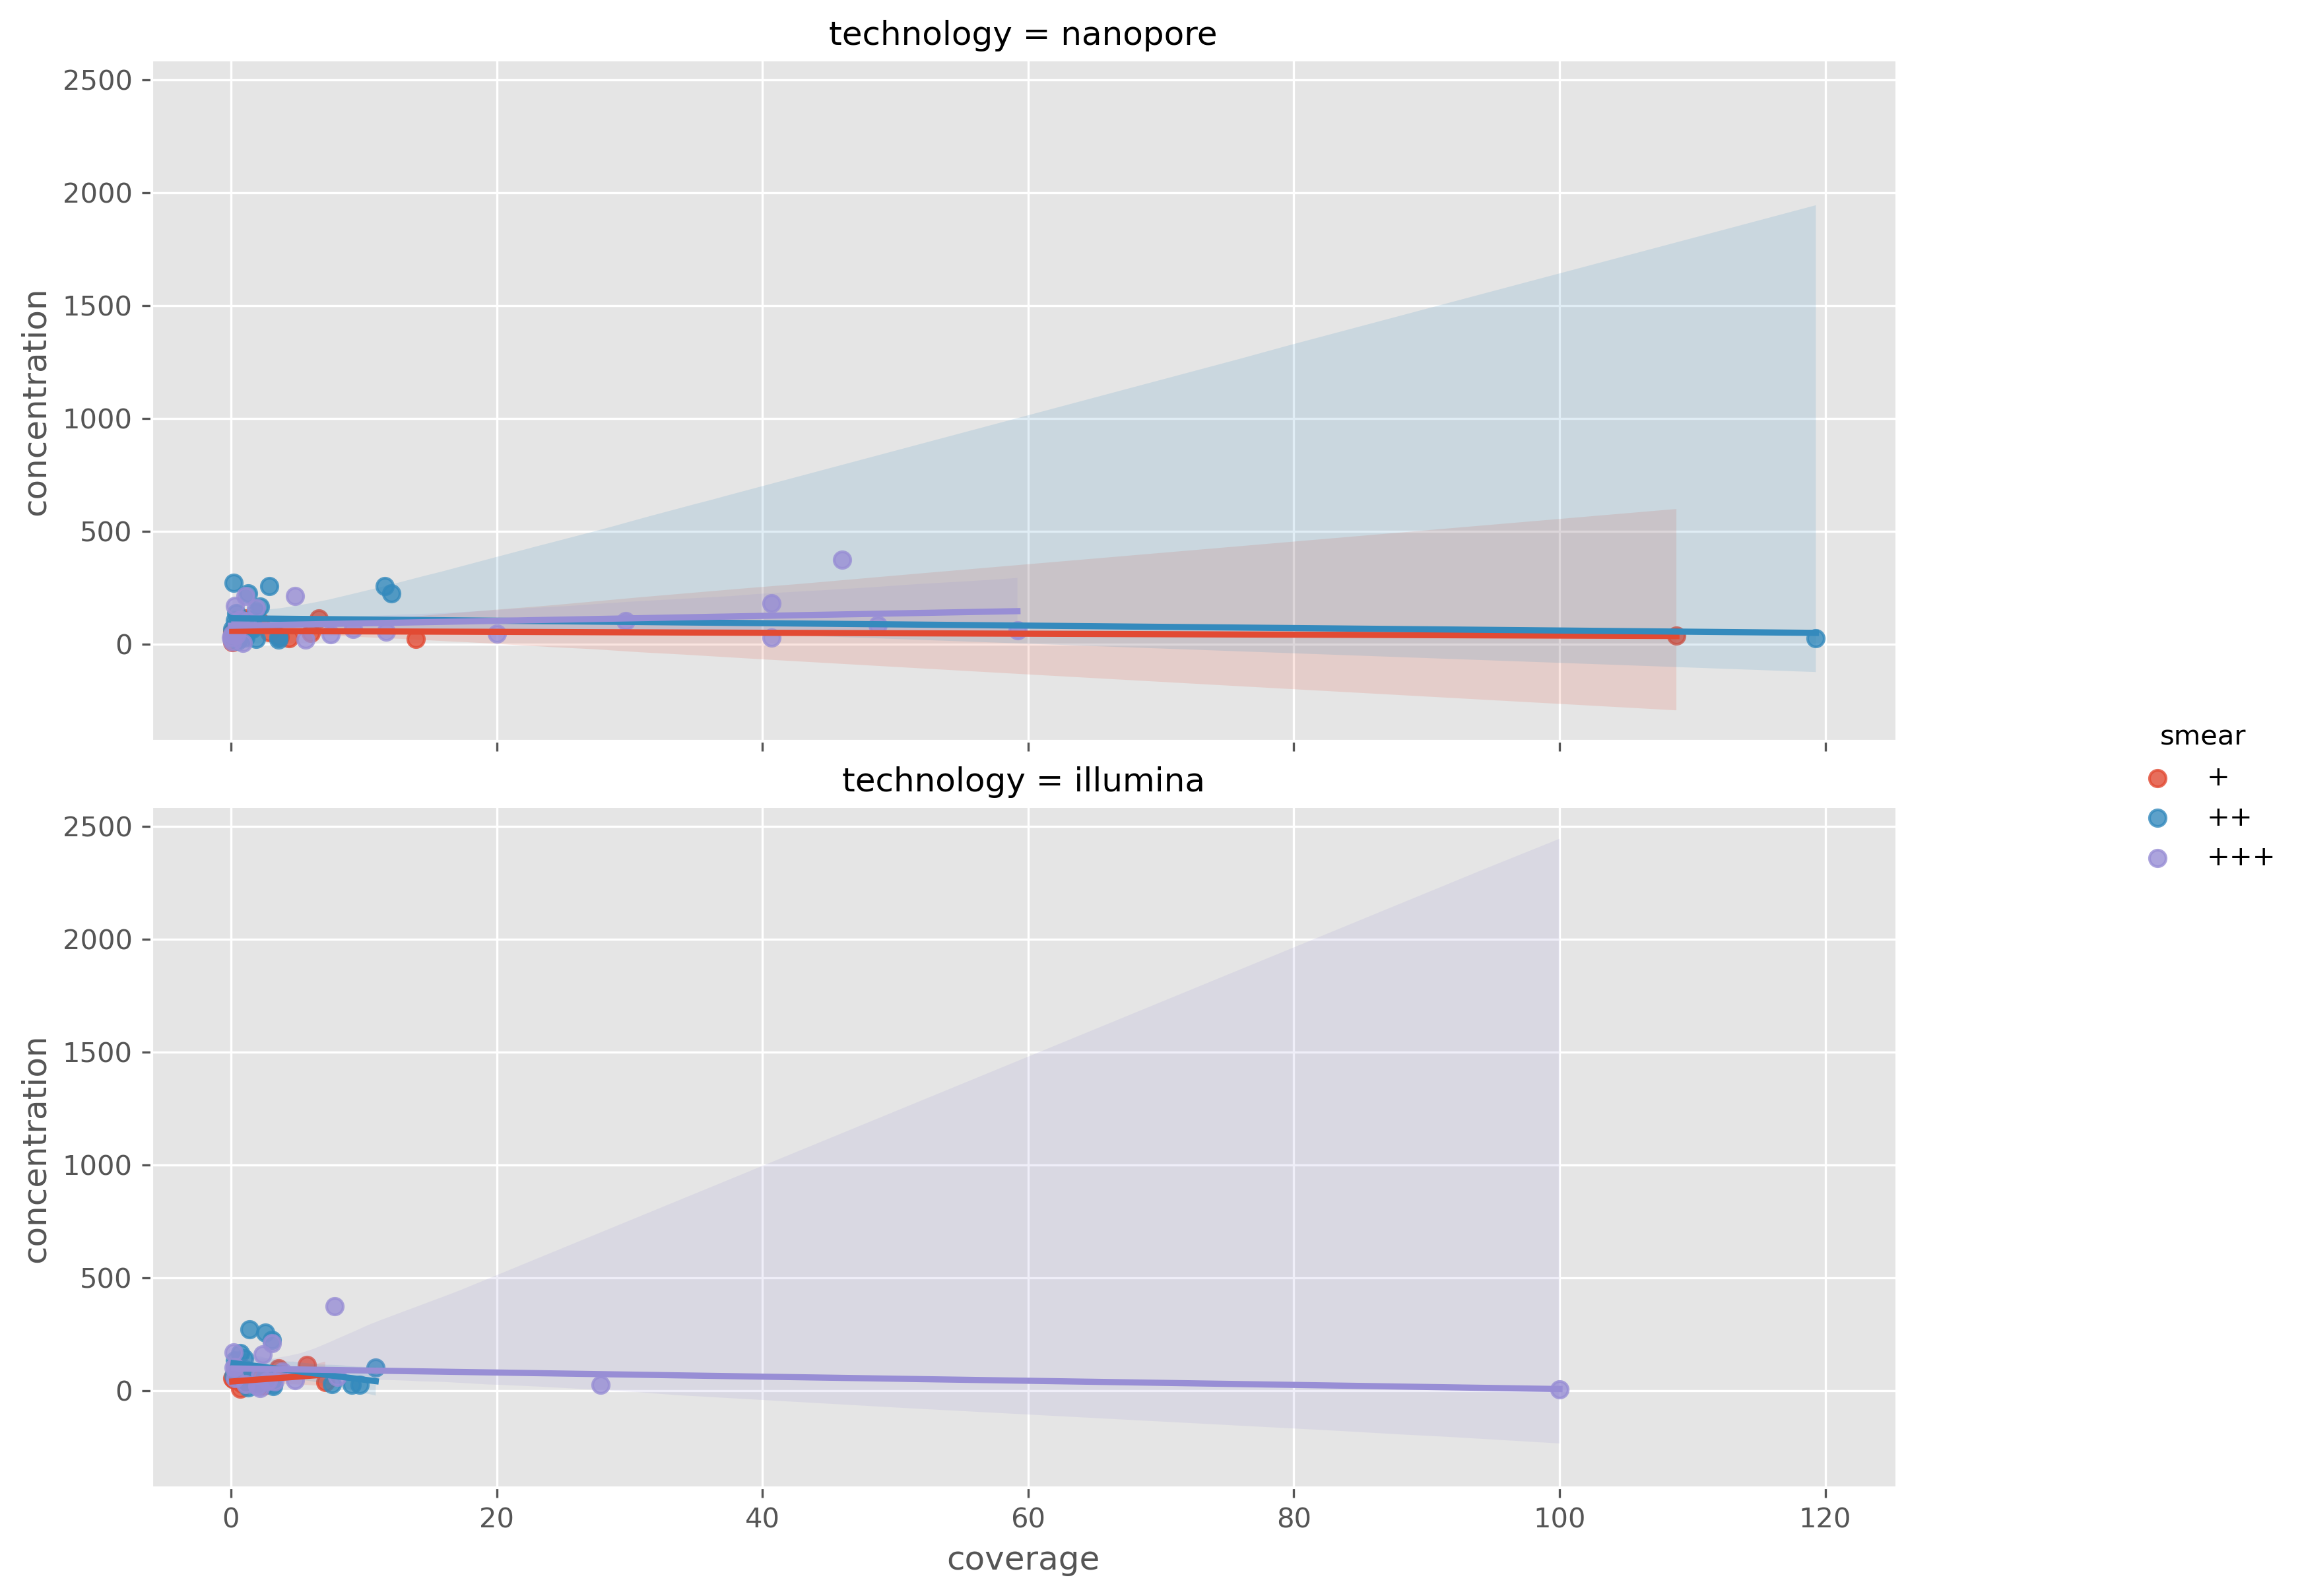

In [65]:
# fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
data = lineage_df.query("source=='sputum'")
g = sns.lmplot(data=data, x="coverage", y="concentration", hue="smear", row="technology")
fig = g.fig
fig.set_dpi(300)
fig.set_figheight(8)
fig.set_figwidth(13)
# fig.axes[1].set_xlim((-1, 20))

In [66]:
lineage_df.to_csv("../../../../Downloads/lineage.csv")

<AxesSubplot:xlabel='coverage', ylabel='concentration'>

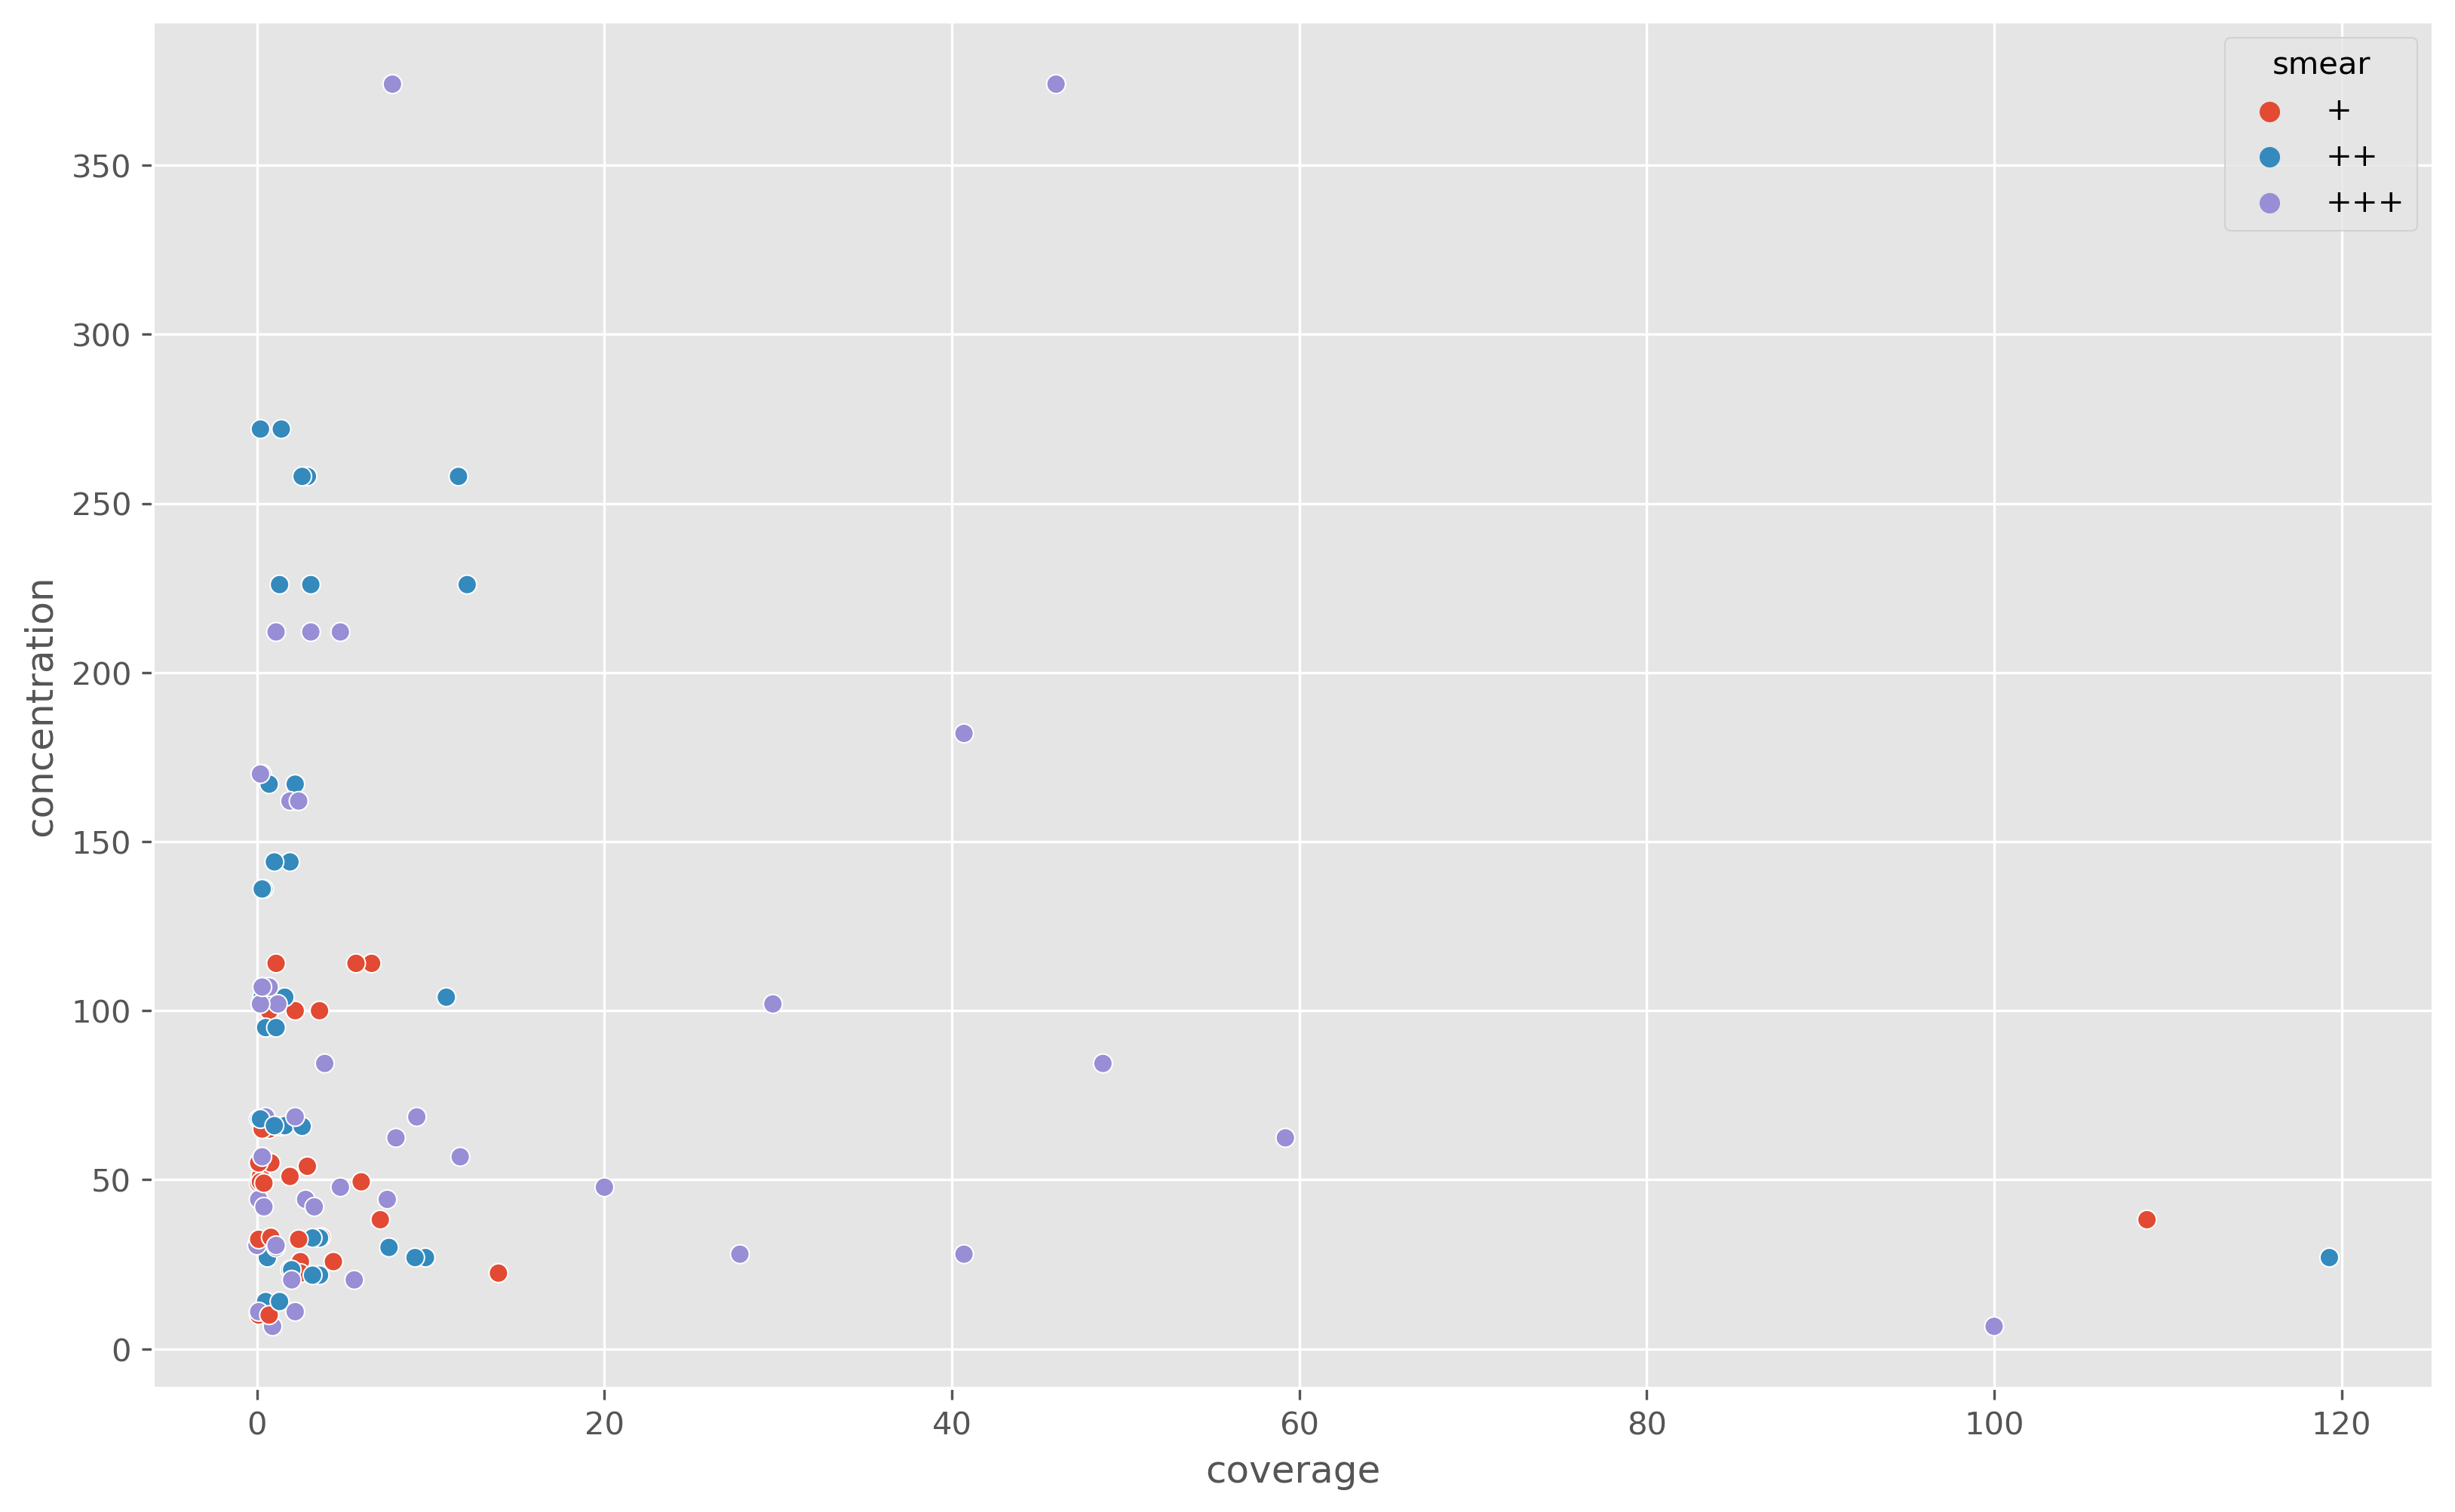

In [67]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.scatterplot(data=data, x="coverage", y="concentration", hue="smear")